In [2]:
import ast
import time
import math
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from math import pi, sqrt
from numpy import arccos, arctan2
from qiskit.visualization.bloch import Bloch
from qiskit import transpile
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram, plot_bloch_multivector, plot_bloch_vector
from qiskit.circuit.library import RYGate, XGate
from qiskit_aer import Aer


In [51]:
Q = np.array([1,1])
angle = np.pi/6
rot = np.array([[np.cos(angle), -np.sin(angle)],
                       [np.sin(angle), np.cos(angle)]])
Q_rot = np.dot(rot, Q)
print(Q_rot)

[0.3660254 1.3660254]


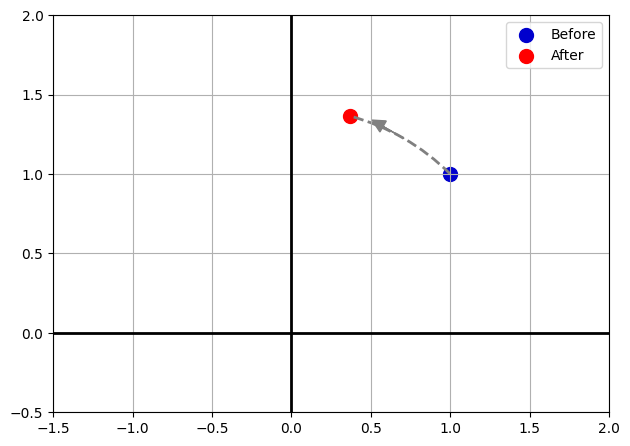

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arc

# 원래 점
Q = np.array([1, 1])

# 전체 회전 각도
theta_deg = 30
theta_rad = np.deg2rad(theta_deg)

# 회전 행렬
rotation_matrix = np.array([
    [np.cos(theta_rad), -np.sin(theta_rad)],
    [np.sin(theta_rad),  np.cos(theta_rad)]
])
Q_rot = rotation_matrix @ Q

# 반지름
radius = np.linalg.norm(Q)

# 시작 각도 (Q의 방향)
theta_start = np.rad2deg(np.arctan2(Q[1], Q[0]))  # 45도
theta_end = theta_start + theta_deg               # 75도

# ▶️ 화살표를 넣을 각도: Q에서 15도 회전한 지점
theta_arrow = theta_start + 15
theta_arrow_rad = np.deg2rad(theta_arrow)

# 화살표 위치 (호 위 좌표)
arrow_pos_x = radius * np.cos(theta_arrow_rad)
arrow_pos_y = radius * np.sin(theta_arrow_rad)

# 접선 방향 (반시계 방향 기준)
tangent_dx = -np.sin(theta_arrow_rad)
tangent_dy =  np.cos(theta_arrow_rad)

# 화살표 크기
arrow_len = 0.25
arrow_dx = arrow_len * tangent_dx
arrow_dy = arrow_len * tangent_dy


# 화살표 크기 줄이기
arrow_len = 0.15
arrow_dx = arrow_len * tangent_dx
arrow_dy = arrow_len * tangent_dy

# 시각화
fig, ax = plt.subplots()

# 작아진 화살표 추가
ax.arrow(arrow_pos_x, arrow_pos_y, arrow_dx, arrow_dy,
         head_width=0.04, head_length=0.05, fc='gray', ec='gray')

# 점 시각화
point_size = 100
point_color = 'mediumblue'
ax.scatter(Q[0], Q[1], s=point_size, color=point_color, label='Before')
ax.scatter(Q_rot[0], Q_rot[1], s=point_size, color='red', label='After')

# 회전 경로 호 추가
arc = Arc((0, 0), 2*radius, 2*radius, angle=0, theta1=theta_start, theta2=theta_end,
          color='gray', linestyle='--', linewidth=2)
ax.add_patch(arc)

# 화살표 추가 (Q에서 15도 회전한 지점에 접선 방향으로)
ax.arrow(arrow_pos_x, arrow_pos_y, arrow_dx, arrow_dy,
         head_width=0.08, head_length=0.08, fc='gray', ec='gray')

# 기준 축 (x=0, y=0)
ax.axhline(y=0, color='black', linewidth=2)
ax.axvline(x=0, color='black', linewidth=2)

# 기타 설정
ax.set_xlim(-1.5, 2)
ax.set_ylim(-0.5, 2)
ax.set_aspect('equal')
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


In [173]:
radius = []
k_list = []
size_list = []
def project(img, n):
    global radius
    (row, col, _) = img
    x = row
    y = col
    z = 0
    r = round(np.sqrt(2**(2*n)/(8 * np.pi)),4)
    radius.append(r)
    Q = np.array([x, y, z], dtype=np.float32)
    X = get_2d_to_3d(Q,r)
    return X

def get_2d_to_3d(point,r):
    global size_list, k_list
    [x, y, _] = point
    k = round(4*r**2 / (x**2 + y**2 + 4*r**2), 4)
    P = np.array([k * x, k * y, (1-2*k)*r ])
    size = np.sqrt(P[0]**2+P[1]**2+P[2]**2)
    resize = P*(1/size)
    k = k * (1/size)
    size_list.append(size)
    k_list.append(k)
    return resize
Q_3d = np.array([1,1,0])
Q_3d_proj  = project(Q_3d,1)
Q_rot_3d = np.array([Q_rot[0],Q_rot[1],0])
Q_rot_3d_proj = project(Q_rot_3d,1)
print(Q_3d_proj, Q_rot_3d_proj)

[0.60518137 0.60518137 0.51721467] [0.22151176 0.82669313 0.51721466]


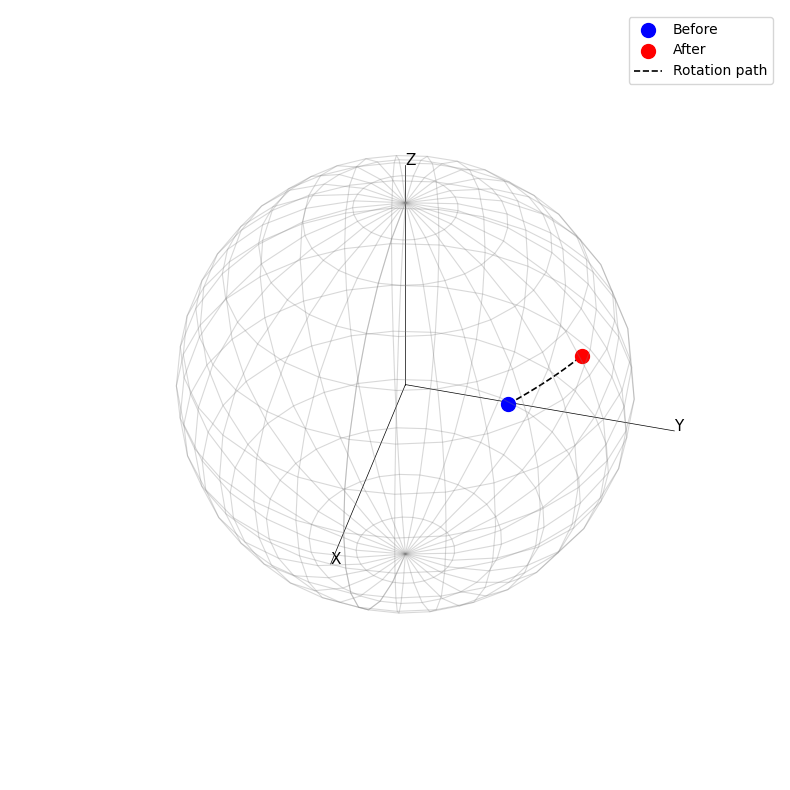

In [174]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 주어진 좌표 (unit sphere 위)
Q_3d_proj = np.array([0.60518137, 0.60518137, 0.51721467])
Q_rot_3d_proj = np.array([0.22151176  , 0.82669313  , 0.51721466 ])

def slerp(p0, p1, t_array):
    omega = np.arccos(np.clip(np.dot(p0, p1), -1, 1))
    so = np.sin(omega)
    if so == 0:
        return np.outer(1 - t_array, p0) + np.outer(t_array, p1)
    return (np.sin((1 - t_array) * omega) / so)[:, None] * p0 + (np.sin(t_array * omega) / so)[:, None] * p1

t_vals = np.linspace(0, 1, 100)
arc_points = slerp(Q_3d_proj, Q_rot_3d_proj, t_vals)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# 구 격자 생성
u = np.linspace(0, 2 * np.pi, 30)
v = np.linspace(0, np.pi, 15)
x_sphere = np.outer(np.cos(u), np.sin(v))
y_sphere = np.outer(np.sin(u), np.sin(v))
z_sphere = np.outer(np.ones_like(u), np.cos(v))

# 격자망으로 구 그리기
ax.plot_wireframe(x_sphere, y_sphere, z_sphere, color='gray', linewidth=0.8, alpha=0.3)

# 점 표시
ax.scatter(*Q_3d_proj, color='blue', s=100, label='Before')
ax.scatter(*Q_rot_3d_proj, color='red', s=100, label='After')

# 회전 경로 (호) 표시
ax.plot(arc_points[:,0], arc_points[:,1], arc_points[:,2], color='black', linestyle='--', linewidth=1.2, label='Rotation path')

ax.set_box_aspect([1,1,1])
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.axis('off')  # 기본 좌표 축 모두 숨기기

# 축선 직접 그림
axis_len = 1.2
ax.plot([0, axis_len], [0, 0], [0, 0], color='black', linewidth=0.5)
ax.plot([0, 0], [0, axis_len], [0, 0], color='black', linewidth=0.5)
ax.plot([0, 0], [0, 0], [0, axis_len], color='black', linewidth=0.5)

ax.text(axis_len, 0, 0, 'X', fontsize=11, color='black')
ax.text(0, axis_len, 0, 'Y', fontsize=11, color='black')
ax.text(0, 0, axis_len, 'Z', fontsize=11, color='black')


ax.legend()
ax.view_init(elev=40, azim=15)
plt.tight_layout()
plt.show()


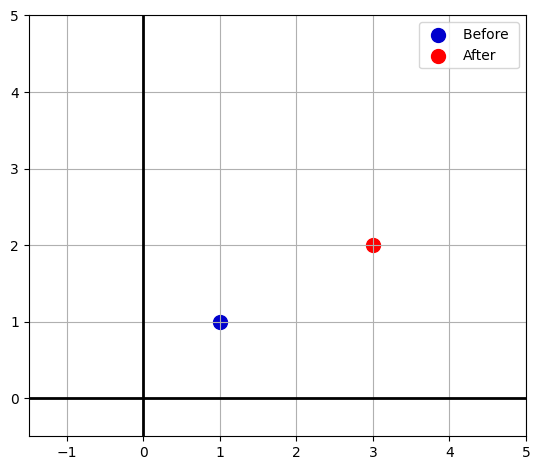

In [188]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arc

# 원래 점
Q = np.array([1, 1])

Q_tra = np.array([3,2])

# 반지름
radius = np.linalg.norm(Q)

# 시작 각도 (Q의 방향)
theta_start = np.rad2deg(np.arctan2(Q[1], Q[0]))  # 45도
theta_end = theta_start + theta_deg               # 75도

# ▶️ 화살표를 넣을 각도: Q에서 15도 회전한 지점
theta_arrow = theta_start + 15
theta_arrow_rad = np.deg2rad(theta_arrow)

# 화살표 위치 (호 위 좌표)
arrow_pos_x = radius * np.cos(theta_arrow_rad)
arrow_pos_y = radius * np.sin(theta_arrow_rad)

# 접선 방향 (반시계 방향 기준)
tangent_dx = -np.sin(theta_arrow_rad)
tangent_dy =  np.cos(theta_arrow_rad)

# 화살표 크기
arrow_len = 0.25
arrow_dx = arrow_len * tangent_dx
arrow_dy = arrow_len * tangent_dy


# 화살표 크기 줄이기
arrow_len = 0.15
arrow_dx = arrow_len * tangent_dx
arrow_dy = arrow_len * tangent_dy

# 작아진 화살표 추가
ax.arrow(arrow_pos_x, arrow_pos_y, arrow_dx, arrow_dy,
         head_width=0.04, head_length=0.05, fc='gray', ec='gray')

# 시각화
fig, ax = plt.subplots()

# 점 시각화
point_size = 100
point_color = 'mediumblue'
ax.scatter(Q[0], Q[1], s=point_size, color=point_color, label='Before ')
ax.scatter(Q_tra[0], Q_tra[1], s=point_size, color='red', label='After')

# 회전 경로 호 추가
arc = Arc((0, 0), 2*radius, 2*radius, angle=0, theta1=theta_start, theta2=theta_end,
          color='gray', linestyle='--', linewidth=2)
#ax.add_patch(arc)

# 화살표 추가 (Q에서 15도 회전한 지점에 접선 방향으로)
#ax.arrow(arrow_pos_x, arrow_pos_y, arrow_dx, arrow_dy,
         #head_width=0.08, head_length=0.08, fc='gray', ec='gray')

# 기준 축 (x=0, y=0)
ax.axhline(y=0, color='black', linewidth=2)
ax.axvline(x=0, color='black', linewidth=2)

# 기타 설정
ax.set_xlim(-1.5, 5)
ax.set_ylim(-0.5, 5)
ax.set_aspect('equal')
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


In [189]:
radius = []
k_list = []
size_list = []
def project(img, n):
    global radius
    (row, col, _) = img
    x = row
    y = col
    z = 0
    r = round(np.sqrt(2**(2*n)/(8 * np.pi)),4)
    radius.append(r)
    Q = np.array([x, y, z], dtype=np.float32)
    X = get_2d_to_3d(Q,r)
    return X

def get_2d_to_3d(point,r):
    global size_list, k_list
    [x, y, _] = point
    k = round(4*r**2 / (x**2 + y**2 + 4*r**2), 4)
    P = np.array([k * x, k * y, (1-2*k)*r ])
    size = np.sqrt(P[0]**2+P[1]**2+P[2]**2)
    resize = P*(1/size)
    k = k * (1/size)
    size_list.append(size)
    k_list.append(k)
    return resize
Q_3d = np.array([1,1,0])
Q_3d_proj  = project(Q_3d,1)
Q_tra_3d = np.array([Q_tra[0],Q_tra[1],0])
Q_tra_3d_proj = project(Q_tra_3d,1)
print(Q_3d_proj, Q_tra_3d_proj)

[0.60518137 0.60518137 0.51721467] [0.35119837 0.23413225 0.9065549 ]


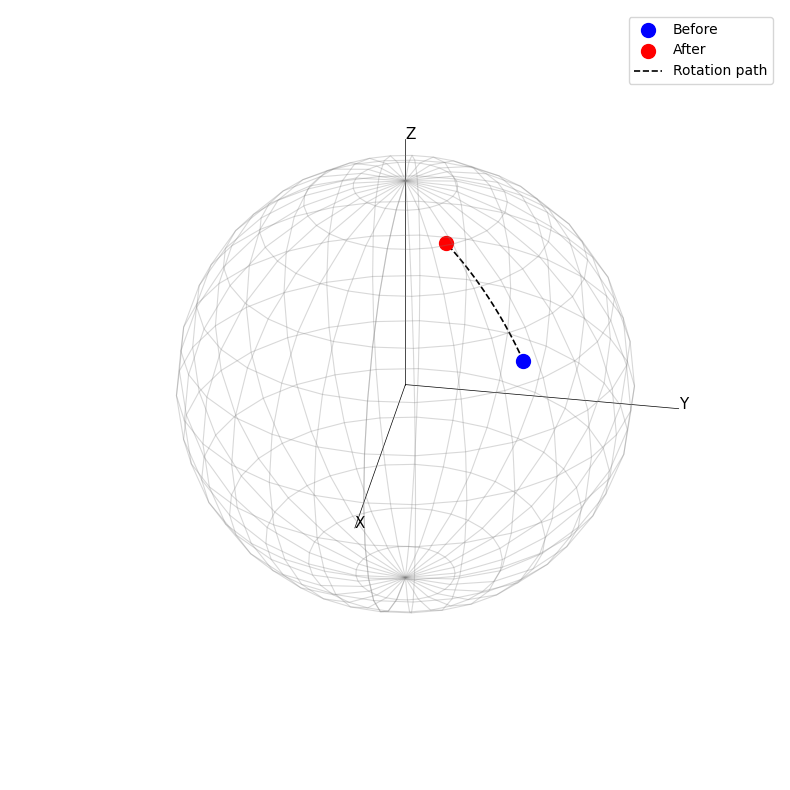

In [209]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 주어진 좌표 (unit sphere 위)
Q_3d_proj = np.array([0.60518137, 0.60518137, 0.51721467])
Q_tra_3d_proj = np.array([0.35119837 , 0.23413225 , 0.9065549 ])

def slerp(p0, p1, t_array):
    omega = np.arccos(np.clip(np.dot(p0, p1), -1, 1))
    so = np.sin(omega)
    if so == 0:
        return np.outer(1 - t_array, p0) + np.outer(t_array, p1)
    return (np.sin((1 - t_array) * omega) / so)[:, None] * p0 + (np.sin(t_array * omega) / so)[:, None] * p1

t_vals = np.linspace(0, 1, 100)
arc_points = slerp(Q_3d_proj, Q_tra_3d_proj, t_vals)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# 구 격자 생성
u = np.linspace(0, 2 * np.pi, 30)
v = np.linspace(0, np.pi, 15)
x_sphere = np.outer(np.cos(u), np.sin(v))
y_sphere = np.outer(np.sin(u), np.sin(v))
z_sphere = np.outer(np.ones_like(u), np.cos(v))

# 격자망으로 구 그리기
ax.plot_wireframe(x_sphere, y_sphere, z_sphere, color='gray', linewidth=0.8, alpha=0.3)

# 점 표시
ax.scatter(*Q_3d_proj, color='blue', s=100, label='Before')
ax.scatter(*Q_tra_3d_proj, color='red', s=100, label='After')

# 회전 경로 (호) 표시
ax.plot(arc_points[:,0], arc_points[:,1], arc_points[:,2], color='black', linestyle='--', linewidth=1.2, label='Rotation path')

ax.set_box_aspect([1,1,1])
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.axis('off')  # 기본 좌표 축 모두 숨기기

# 축선 직접 그림
axis_len = 1.2
ax.plot([0, axis_len], [0, 0], [0, 0], color='black', linewidth=0.5)
ax.plot([0, 0], [0, axis_len], [0, 0], color='black', linewidth=0.5)
ax.plot([0, 0], [0, 0], [0, axis_len], color='black', linewidth=0.5)

ax.text(axis_len, 0, 0, 'X', fontsize=11, color='black')
ax.text(0, axis_len, 0, 'Y', fontsize=11, color='black')
ax.text(0, 0, axis_len, 'Z', fontsize=11, color='black')


ax.legend()
ax.view_init(elev=30, azim=10)
plt.tight_layout()
plt.show()


# Grayscale space

In [23]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import os

# MNIST 데이터셋 로드
transform = transforms.ToTensor()
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# digit별로 정렬된 이미지와 레이블 저장용 리스트
all_padded_images = []
all_labels = []

# 각 숫자별로 100장씩 수집
for target_digit in range(10):
    count = 0
    for img, label in mnist_dataset:
        if label == target_digit:
            # 28x28 → 32x32 zero padding
            padded_img = F.pad(img, pad=(2, 2, 2, 2), mode='constant', value=0)  # shape: [1, 32, 32]
            all_padded_images.append(padded_img.numpy())  # (1, 32, 32)
            all_labels.append(label)
            count += 1
            if count >= 100:
                break

# numpy 배열로 변환
images_np = np.stack(all_padded_images)  # (1000, 1, 32, 32)
labels_np = np.array(all_labels)         # (1000,)

print("이미지 shape:", images_np.shape)
print("레이블 shape:", labels_np.shape)


✅ 저장 완료: mnist_padded_sorted_numpy/
이미지 shape: (1000, 1, 32, 32)
레이블 shape: (1000,)


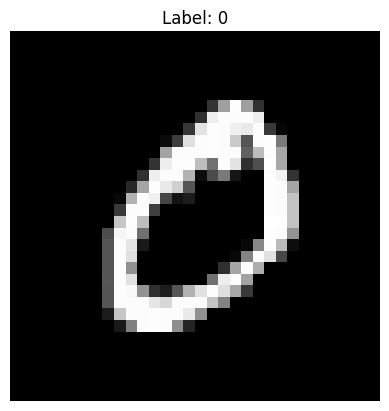

In [24]:
# 첫 번째 이미지 및 라벨
first_image = images_np[0]         # shape: (1, 32, 32)
first_label = labels_np[0]

# 시각화: 채널 축 제거 (1x32x32 → 32x32)
plt.imshow(first_image.squeeze(), cmap='gray')
plt.title(f"Label: {first_label}")
plt.axis('off')
plt.show()

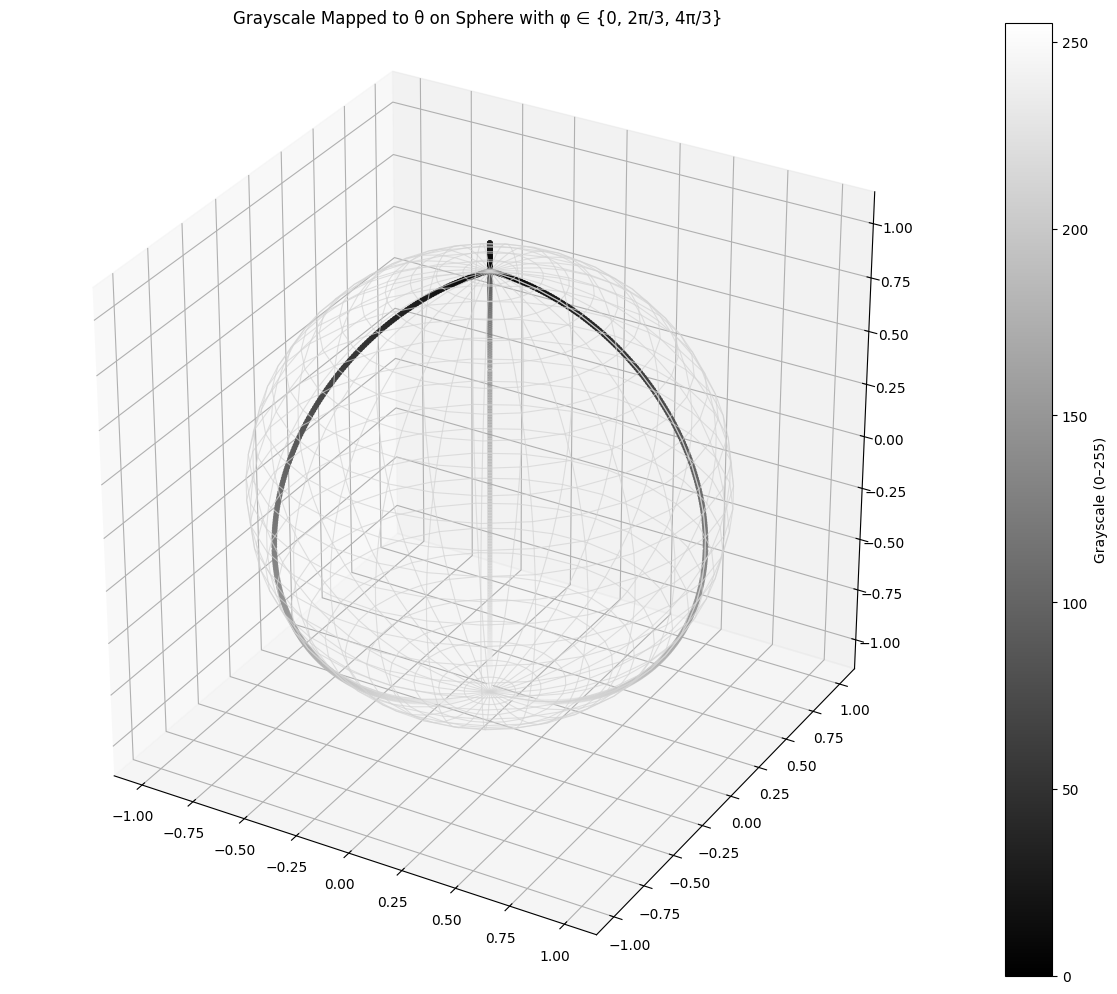

In [3]:
# (1) Grayscale → θ 변환 함수
def grayscale_to_theta(grayscale_value):
    pi = np.pi
    if grayscale_value == 0:
        return 0.0
    elif 1 <= grayscale_value <= 127:
        return (grayscale_value * pi / 255) - (pi / 1020)
    elif 128 <= grayscale_value <= 254:
        return (grayscale_value * pi / 255) + (pi / 1020)
    elif grayscale_value == 255:
        return pi
    else:
        raise ValueError("Grayscale value must be in 0–255")

# (2) θ 값 계산
grayscale_vals = np.arange(0, 256)
theta_vals = np.array([grayscale_to_theta(g) for g in grayscale_vals])

# (3) 고정된 φ 값 3개
phi_fixed = np.array([0, 2 * np.pi / 3, 4 * np.pi / 3])

# (4) 반복 구성
theta_rep = np.repeat(theta_vals, 3)
phi_rep = np.tile(phi_fixed, 256)
grayscale_rep = np.repeat(grayscale_vals, 3)

# (5) 구면 → 3D 좌표 변환
r = 1
x = r * np.sin(theta_rep) * np.cos(phi_rep)
y = r * np.sin(theta_rep) * np.sin(phi_rep)
z = r * np.cos(theta_rep)

# (6) 구 표면 wireframe 좌표 생성
u = np.linspace(0, 2 * np.pi, 30)
v = np.linspace(0, np.pi, 30)
sphere_x = np.outer(np.sin(v), np.cos(u))
sphere_y = np.outer(np.sin(v), np.sin(u))
sphere_z = np.outer(np.cos(v), np.ones_like(u))

# (7) 시각화
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# 구 wireframe
ax.plot_wireframe(sphere_x, sphere_y, sphere_z, color='lightgray', linewidth=0.8, alpha=0.7)

# grayscale 점 시각화
sc = ax.scatter(x, y, z, c=grayscale_rep, cmap='gray', s=10)

# 스타일
ax.set_title('Grayscale Mapped to θ on Sphere with φ ∈ {0, 2π/3, 4π/3}')
ax.set_box_aspect([1, 1, 1])
plt.colorbar(sc, label='Grayscale (0–255)')
plt.tight_layout()
plt.show()


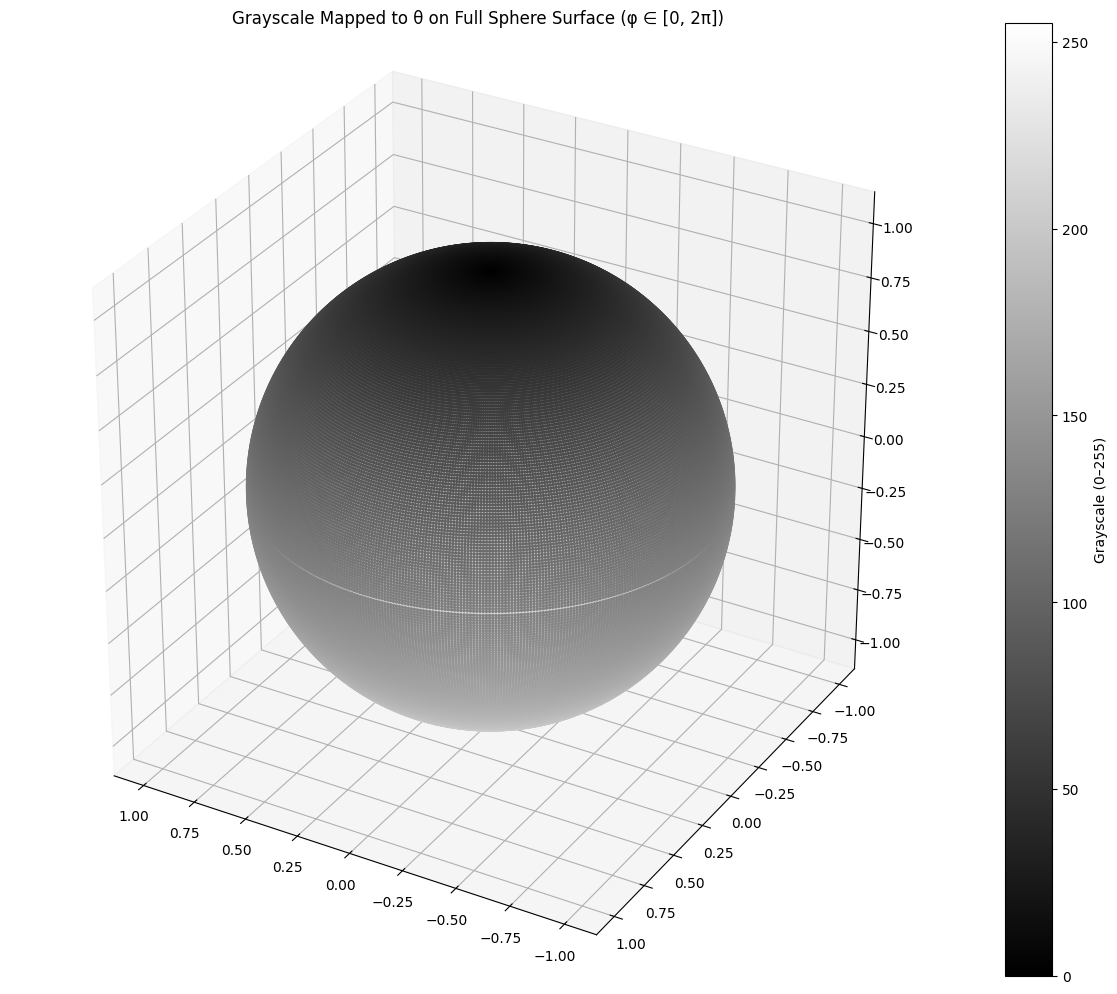

In [211]:
# Re-import after reset
import numpy as np
import matplotlib.pyplot as plt

# (1) Grayscale → θ 변환 함수
def grayscale_to_theta(grayscale_value):
    pi = np.pi
    if grayscale_value == 0:
        return 0.0
    elif 1 <= grayscale_value <= 127:
        return (grayscale_value * pi / 255) - (pi / 1020)
    elif 128 <= grayscale_value <= 254:
        return (grayscale_value * pi / 255) + (pi / 1020)
    elif grayscale_value == 255:
        return pi
    else:
        raise ValueError("Grayscale value must be in 0–255")

# (2) θ 값 계산
grayscale_vals = np.arange(0, 256)
theta_vals = np.array([grayscale_to_theta(g) for g in grayscale_vals])

# (3) φ 값 0부터 2π까지 고르게 분포
phi_vals = np.linspace(0, 2 * np.pi, 500)  # 100개의 φ 값

# (4) 반복 구성
theta_grid, phi_grid = np.meshgrid(theta_vals, phi_vals)
theta_flat = theta_grid.flatten()
phi_flat = phi_grid.flatten()
grayscale_rep = np.tile(grayscale_vals, len(phi_vals))

# (5) 구면 → 3D 좌표 변환
r = 1
x = r * np.sin(theta_flat) * np.cos(phi_flat)
y = r * np.sin(theta_flat) * np.sin(phi_flat)
z = r * np.cos(theta_flat)

# (6) 구 표면 wireframe 좌표 생성
u = np.linspace(0, 2 * np.pi, 30)
v = np.linspace(0, np.pi, 30)
sphere_x = np.outer(np.sin(v), np.cos(u))
sphere_y = np.outer(np.sin(v), np.sin(u))
sphere_z = np.outer(np.cos(v), np.ones_like(u))

# (7) 시각화
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# 구 wireframe
ax.plot_wireframe(sphere_x, sphere_y, sphere_z, color='lightgray', linewidth=0.8, alpha=0.5)

# grayscale 점 시각화
sc = ax.scatter(x, y, z, c=grayscale_rep, cmap='gray', s=2)

# 스타일
ax.set_title('Grayscale Mapped to θ on Full Sphere Surface (φ ∈ [0, 2π])')
ax.set_box_aspect([1, 1, 1])
ax.view_init(elev=30, azim=120)

plt.colorbar(sc, label='Grayscale (0–255)')
plt.tight_layout()
plt.show()


In [215]:
# θ 값 배열 생성
grayscale_vals = np.arange(0, 256)
theta_vals = np.array([grayscale_to_theta(g) for g in grayscale_vals])

# 중앙 기반 범위 계산
theta_mid = (theta_vals[:-1] + theta_vals[1:]) / 2
theta_lower = np.concatenate(([theta_vals[0]], theta_mid))
theta_upper = np.concatenate((theta_mid, [theta_vals[-1]]))

# DataFrame 생성 및 저장
df = pd.DataFrame({
    'grayscale': grayscale_vals,
    'theta': theta_vals,
    'theta_lower': theta_lower,
    'theta_upper': theta_upper
})

df.to_csv("grayscale_theta_bounds.csv", index=False)

In [117]:
# LUT 파일 불러오기
lut_df = pd.read_csv("grayscale_theta_bounds.csv")

# numpy array로 변환 (성능 향상)
lut_theta = lut_df['theta'].values
lut_grayscale = lut_df['grayscale'].values

In [29]:
import numpy as np

def grayscale_to_theta(grayscale_value):
    pi = np.pi
    if grayscale_value == 0:
        return 0.0
    elif 1 <= grayscale_value <= 127:
        return (grayscale_value * pi / 255) - (pi / 1020)
    elif 128 <= grayscale_value <= 254:
        return (grayscale_value * pi / 255) + (pi / 1020)
    elif grayscale_value == 255:
        return pi

# theta 값을 저장할 리스트
all_theta_images = []

for i in range(len(images_np)):
    img_uint8 = (images_np[i] * 255).astype(np.uint8).squeeze()  # (32, 32)
    
    # np.vectorize로 함수 벡터화
    vectorized_func = np.vectorize(grayscale_to_theta)
    
    theta_img = vectorized_func(img_uint8)  # shape: (32, 32), float
    
    all_theta_images.append(theta_img)

all_theta_images = np.array(all_theta_images)  # shape: (1000, 32, 32)

print(all_theta_images.shape)
print(all_theta_images[0])  # 첫 이미지의 theta 값 출력


(1000, 32, 32)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [68]:
def fill_missing_theta_for_state_0(pixel_theta):
    # (1) 모든 가능한 theta 10bit 문자열
    all_theta = {format(i, '010b') for i in range(1024)}

    # (2) 기존 pixel_theta 중 state가 '0'인 것만 필터링
    state_0_entries = [(state, theta, amount) for state, theta, amount in pixel_theta if state == '0']

    # (3) 존재하는 theta 추출
    existing_theta_0 = {theta for state, theta, amount in state_0_entries}

    # (4) 누락된 theta 확인
    missing_theta_0 = all_theta - existing_theta_0

    # (5) 누락된 항목을 amount=0으로 추가
    filled_entries = list(pixel_theta)  # 원본 복사

    for theta in missing_theta_0:
        filled_entries.append(('0', theta, 0))

    return filled_entries

def sort_by_theta_bin(filled_pixel_theta):
    return sorted(filled_pixel_theta, key=lambda x: int(x[1], 2))

In [146]:
start = time.time()

len_im = all_theta_images[0].flatten().shape[0]
thetas = []
for i in range(len_im):
    theta = round(all_theta_images[0].flatten()[i]/2,4)
    thetas.append(theta)

w_bits = int(np.ceil(math.log(images_np[0].squeeze().shape[1], 2)))
h_bits = int(np.ceil(math.log(images_np[0].squeeze().shape[0], 2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

num_ind_bits = int(h_bits + w_bits)

if not num_ind_bits:
    num_ind_bits = 1

O = QuantumRegister(w_bits+h_bits, 'q1')
c = QuantumRegister(1,'q0')
cr = ClassicalRegister(O.size+c.size, "cl")

qc_image = QuantumCircuit(c,O, cr)

qc_image.id(c)
qc_image.h(O)

qc_image.barrier()

controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])

for i, theta in enumerate(thetas):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind): 
            qc_image.barrier()
            qc_image.x(O[k])

    for coord_or_intns in (0,1):
        if not coord_or_intns:  
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])

qc_image.x(O)

qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc_image, aer_sim)
result = aer_sim.run(t_qc_image, shots=8000000).result()
counts = result.get_counts()
end = time.time()
print(f"{end - start:.5f} sec")
pixel_theta_recon = []
pixel_theta = []

for i in range(len_im):
    for item in counts.items():
        key = item[0]
        amount = item[1]
        state = key[0]
        bin_coord = key[1:]
        int_coord = int(bin_coord, 2)
        if int_coord == i:
            pixel_theta.append((state,bin_coord, amount))

# ======================== theta ===================================

theta_result_dict = {}
for state in pixel_theta:
    key = state[1]
    value = state[2] 
    if key in theta_result_dict:
        theta_result_dict[key] += value  
    else:
        theta_result_dict[key] = value  

theta_result_list = [(key, value) for key, value in theta_result_dict.items()]

theta_state_0 = []

for state, theta, amount in sort_by_theta_bin(fill_missing_theta_for_state_0(pixel_theta)):
    if not int(state):
        theta_state_0.append((theta, amount))

'''
for state, theta, amount in pixel_theta:
    if not int(state):
        theta_state_0.append((theta, amount))
'''

for i in range(len_im):
    try:
        theta = np.arccos((theta_state_0[i][1]/theta_result_list[i][1])**(1/2))
        pixel_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")
pixel_theta_recon = list(reversed(pixel_theta_recon))

# 1. LUT csv 파일 불러오기
df = pd.read_csv("grayscale_theta_bounds.csv")

# 2. 결과를 저장할 리스트 초기화
reconstructed_grayscale_values = []

# 3. LUT 탐색을 위한 numpy 배열로 변환 (속도 개선 목적)
theta_lowers = df['theta_lower'].to_numpy()
theta_uppers = df['theta_upper'].to_numpy()
grayscale_vals = df['grayscale'].to_numpy()

# 4. 각 복원된 theta 값에 대해 LUT 검색
for theta in pixel_theta_recon:
    # 조건에 맞는 index 찾기
    match_indices = (theta_lowers <= theta) & (theta < theta_uppers)
    if match_indices.any():
        idx = match_indices.argmax()  # 첫 번째로 True인 인덱스
        grayscale = int(grayscale_vals[idx])
    else:
        # 예외 처리: theta가 어떤 구간에도 포함되지 않는 경우
        grayscale = 0  # 또는 255 등 원하는 기본값

    reconstructed_grayscale_values.append(grayscale)

error = []
for i in range(len_im):
    err = reconstructed_grayscale_values[i]-int(images_np[0].flatten()[i]*255)
    error.append(err)

ME_approx = sum(error)/len_im 
print(ME_approx)

42.75552 sec
0.0146484375


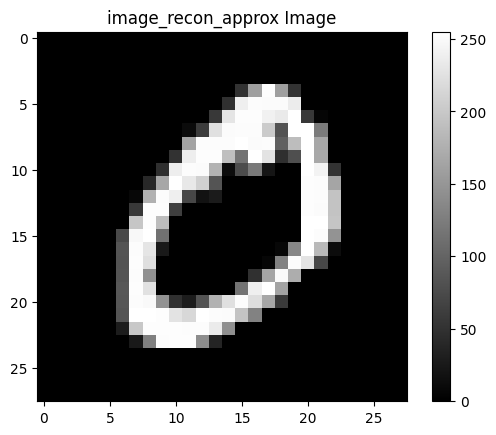

In [120]:
# numpy array로 변환 (선택 사항)
reconstructed_grayscale_values = np.array(reconstructed_grayscale_values)

# (예시) 32x32 이미지로 reshape하여 시각화
image_recon_approx = reconstructed_grayscale_values.reshape(32, 32)[2:-2, 2:-2]

# 시각화
plt.imshow(image_recon_approx, cmap='gray', vmin=0, vmax=255)
plt.title("image_recon_approx Image")
plt.colorbar()
plt.show()

In [116]:
import pandas as pd

# CSV 파일 로드
df = pd.read_csv("grayscale_theta_bounds.csv")

# 잘못된 행 필터링
invalid_bounds = df[df['theta_lower'] > df['theta_upper']]

# 결과 출력
if not invalid_bounds.empty:
    print("다음 행들에서 theta_lower > theta_upper 오류가 있습니다:")
    print(invalid_bounds)
else:
    print("모든 theta_lower 값이 정상적으로 theta_upper 이하입니다.")


모든 theta_lower 값이 정상적으로 theta_upper 이하입니다.


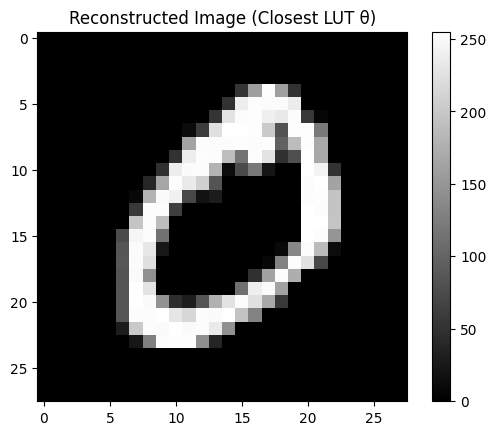

In [102]:
# numpy array로 변환 (선택 사항)
reconstructed_grayscale = np.array(reconstructed_grayscale)

# (예시) 32x32 이미지로 reshape하여 시각화
image_recon = reconstructed_grayscale.reshape(32, 32)[2:-2, 2:-2]

# 시각화
plt.imshow(image_recon, cmap='gray', vmin=0, vmax=255)
plt.title("Reconstructed Image (Closest LUT θ)")
plt.colorbar()
plt.show()


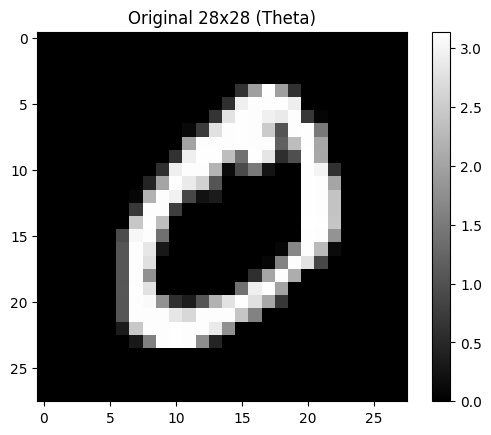

In [109]:
# all_theta_images[0]은 (32, 32) 배열
original_32x32 = all_theta_images[0]

# 동일하게 28x28 크기로 자르기

original_28x28 = original_32x32[2:-2, 2:-2]
plt.imshow(original_28x28, cmap='gray')
plt.title("Original 28x28 (Theta)")
plt.colorbar()
plt.show()

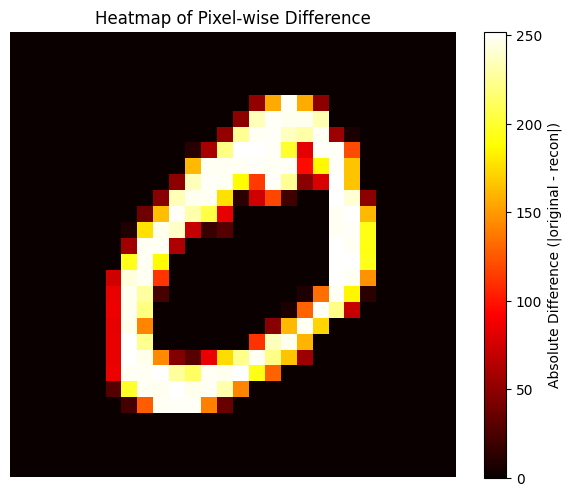

In [113]:
import numpy as np
import matplotlib.pyplot as plt

# 두 이미지 (예: 28x28 또는 32x32 크기)
# 원본 이미지 (0~255)
original_image = all_theta_images[0]  # or your actual reference image
# 복원된 이미지 (LUT 또는 직접 복원)
reconstructed_image = image_recon  # 위에서 만든 grayscale image

# 크기 맞추기 (패딩 제거 등 필요시)
original_image = original_image[2:30, 2:30]  # 예시: 32x32 → 28x28 잘라내기

# 차이 계산 (절대값)
diff = np.abs(original_image.astype(np.float32) - reconstructed_image.astype(np.float32))

# 시각화
plt.figure(figsize=(6, 5))
plt.imshow(diff, cmap='hot')
plt.colorbar(label='Absolute Difference (|original - recon|)')
plt.title("Heatmap of Pixel-wise Difference")
plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
image_recon_approx

import numpy as np
import matplotlib.pyplot as plt

# 예시: pixel_theta_recon (길이 1024 리스트)
pixel_theta_recon = np.array(pixel_theta_recon)  # 리스트 → numpy array

# 255배
pixel_theta_recon_scaled = pixel_theta_recon * 255

# 32x32로 reshape
img_32x32 = pixel_theta_recon_scaled.reshape(32, 32)

# 상하좌우 2픽셀씩 제거
img_28x28 = img_32x32[2:-2, 2:-2]

# all_theta_images[0]은 (32, 32) 배열
original_32x32 = all_theta_images[0]

# 동일하게 28x28 크기로 자르기
original_28x28 = original_32x32[2:-2, 2:-2]

fig, axes = plt.subplots(1, 3, figsize=(8,4))

axes[0].imshow(original_28x28, cmap='gray')
axes[0].set_title("Original 28x28 (Theta)")
axes[0].axis('off')

axes[1].imshow(img_28x28, cmap='gray')
axes[1].set_title("Reconstructed 28x28")
axes[1].axis('off')

axes[2].imshow(image_recon, cmap='gray')
axes[2].set_title("Approx reconstructed 28x28")
axes[2].axis('off')

plt.show()

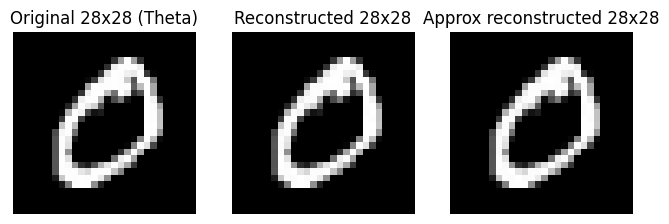

In [107]:
import numpy as np
import matplotlib.pyplot as plt

# 예시: pixel_theta_recon (길이 1024 리스트)
pixel_theta_recon = np.array(pixel_theta_recon)  # 리스트 → numpy array

# 255배
pixel_theta_recon_scaled = pixel_theta_recon * 255

# 32x32로 reshape
img_32x32 = pixel_theta_recon_scaled.reshape(32, 32)

# 상하좌우 2픽셀씩 제거
img_28x28 = img_32x32[2:-2, 2:-2]

# all_theta_images[0]은 (32, 32) 배열
original_32x32 = all_theta_images[0]

# 동일하게 28x28 크기로 자르기
original_28x28 = original_32x32[2:-2, 2:-2]

fig, axes = plt.subplots(1, 3, figsize=(8,4))

axes[0].imshow(original_28x28, cmap='gray')
axes[0].set_title("Original 28x28 (Theta)")
axes[0].axis('off')

axes[1].imshow(img_28x28, cmap='gray')
axes[1].set_title("Reconstructed 28x28")
axes[1].axis('off')

axes[2].imshow(image_recon, cmap='gray')
axes[2].set_title("Approx reconstructed 28x28")
axes[2].axis('off')

plt.show()

In [ ]:
total_mean_error = [] # digit 별로 오차 더한 뒤 digit 수로 나눔
time_per_digit = []
for index in range(0,100):
    start = time.time()

    len_im = all_theta_images[index].flatten().shape[0]
    thetas = []
    for i in range(len_im):
        theta = round(all_theta_images[index].flatten()[i]/2,4)
        thetas.append(theta)

    w_bits = int(np.ceil(math.log(all_theta_images[index].shape[1], 2)))
    h_bits = int(np.ceil(math.log(all_theta_images[index].shape[0], 2)))
    if not w_bits: w_bits = 1
    if not h_bits: h_bits = 1

    num_ind_bits = int(h_bits + w_bits)

    if not num_ind_bits:
        num_ind_bits = 1

    O = QuantumRegister(w_bits+h_bits, 'q1')
    c = QuantumRegister(1,'q0')
    cr = ClassicalRegister(O.size+c.size, "cl")

    qc_image = QuantumCircuit(c,O, cr)

    qc_image.id(c)
    qc_image.h(O)

    qc_image.barrier()

    controls_ = []
    for i, _ in enumerate(O):
        controls_.extend([O[i]])

    for i, theta in enumerate(thetas):
        qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
        
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind): 
                qc_image.barrier()
                qc_image.x(O[k])

        for coord_or_intns in (0,1):
            if not coord_or_intns:  
                qc_image.mcry(theta=2*theta,
                            q_controls=controls_,
                            q_target=c[0])
                qc_image.barrier()
        
        if  i!=len(thetas) - 1:
            for k, qub_ind in enumerate(qubit_index_bin):
                if int(qub_ind):
                    qc_image.x(O[k])

    qc_image.x(O)

    qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

    aer_sim = Aer.get_backend('aer_simulator')
    t_qc_image = transpile(qc_image, aer_sim)
    result = aer_sim.run(t_qc_image, shots=8000000).result()
    counts = result.get_counts()
    end = time.time()
    measure_time = end - start
    time_per_digit.append(measure_time)

    pixel_theta_recon = []
    pixel_theta = []

    for i in range(len_im):
        for item in counts.items():
            key = item[0]
            amount = item[1]
            state = key[0]
            bin_coord = key[1:]
            int_coord = int(bin_coord, 2)
            if int_coord == i:
                pixel_theta.append((state,bin_coord, amount))

    # ======================== theta ===================================

    theta_result_dict = {}
    for state in pixel_theta:
        key = state[1]
        value = state[2] 
        if key in theta_result_dict:
            theta_result_dict[key] += value  
        else:
            theta_result_dict[key] = value  

    theta_result_list = [(key, value) for key, value in theta_result_dict.items()]

    theta_state_0 = []

    for state, theta, amount in sort_by_theta_bin(fill_missing_theta_for_state_0(pixel_theta)):
        if not int(state):
            theta_state_0.append((theta, amount))

    for i in range(len_im):
        try:
            theta = np.arccos((theta_state_0[i][1]/theta_result_list[i][1])**(1/2))
            pixel_theta_recon.append(theta*2)
        except ZeroDivisionError:
            print("ZeroDivisionError")
    pixel_theta_recon = list(reversed(pixel_theta_recon))
    
    for theta in pixel_theta_recon:
        # 조건에 맞는 index 찾기
        match_indices = (theta_lowers <= theta) & (theta < theta_uppers)
        if match_indices.any():
            idx = match_indices.argmax()  # 첫 번째로 True인 인덱스
            grayscale = int(grayscale_vals[idx])
        else:
            # 예외 처리: theta가 어떤 구간에도 포함되지 않는 경우
            grayscale = 0  # 또는 255 등 원하는 기본값

        reconstructed_grayscale_values.append(grayscale)

    for i in range(len_im):
        err = reconstructed_grayscale_values[i]-int(images_np[0].flatten()[i]*255)
        error.append(err)

    ME_approx = sum(error)/len_im 
    total_mean_error.append(ME_approx)

mean_error_result = sum(total_mean_error) / 100
print(mean_error_result)

# RGB color space

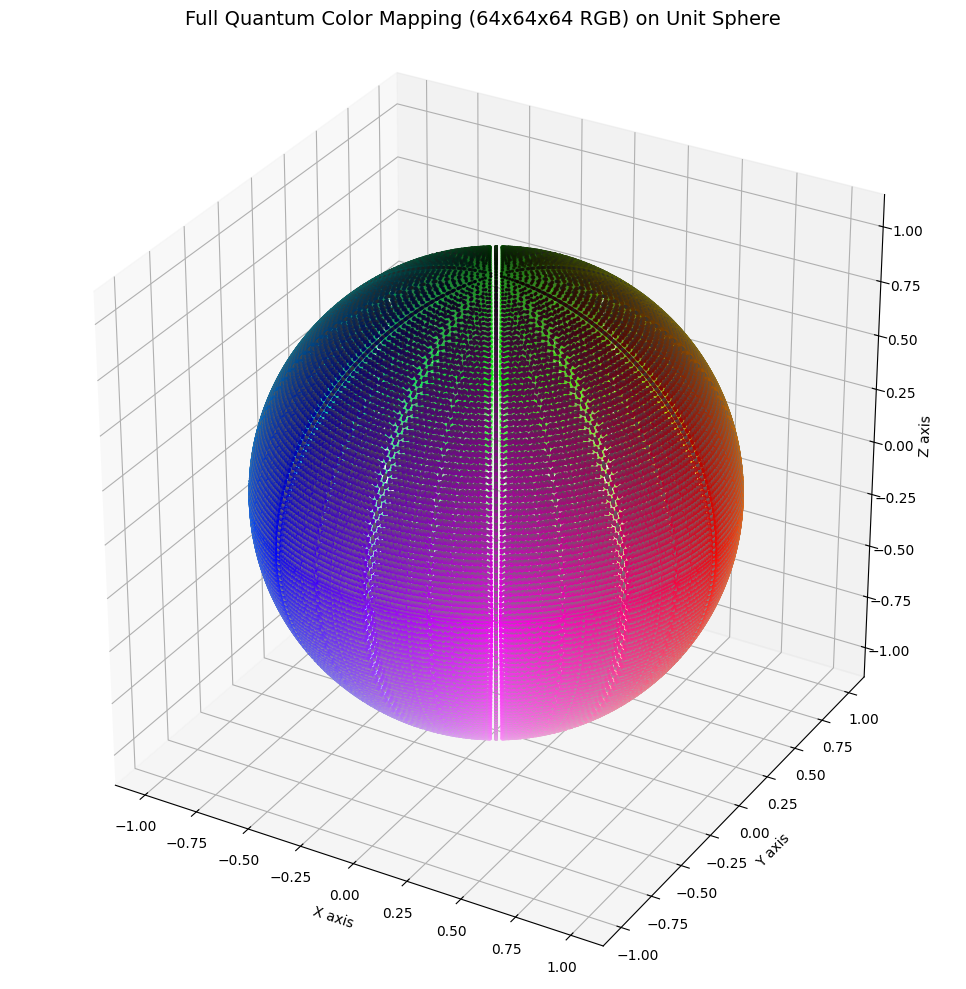

In [220]:
# Re-import after reset
import numpy as np
import matplotlib.pyplot as plt

# θ 계산 함수 (북반구/적도/남반구 식 적용)
def compute_theta(r, g, b):
    n = min(r, g, b)
    m = max(r, g, b)
    l = m + n

    if l < 63:  # 북반구
        a = 63 - l
        max_i = int(np.floor((63 - a) / 2))
        for i in range(1, max_i + 1):
            if m == 63 - a - i and n == i:
                return ((63 - a) * np.pi / 126) + (np.pi / 252) - ((np.pi / 126) * (i + 1) / (max_i + 1))

    elif l == 63:  # 적도
        max_i = int(np.floor(63 / 2))  # 31
        for i in range(max_i + 1):  # 0 ~ 31
            if m == 63 - i and n == i:
                if i == 0:
                    return np.pi / 2
                elif i != 0 and i % 2 == 0:  # 2,4,...,30
                    return np.pi / 2 + np.pi / 252 * i / 30
                elif i != 0 and i % 2 == 1:  # 1,3,...,31
                    return np.pi / 2 - np.pi / 252 * (i + 1) / 32

    elif l > 63:  # 남반구
        a = l - 63
        max_i = int(np.floor((63 - a) / 2))
        for i in range(1, max_i + 1):
            if m == 63 - i and n == a + i:
                return ((63 + a) * np.pi / 126) - (np.pi / 252) + ((np.pi / 126) * (i + 1) / (max_i + 1))

    return l * np.pi / 126  # fallback

# RGB → θ, ϕ 변환
def rgb_to_theta_phi(r, g, b):
    n = min(r, g, b)
    m = max(r, g, b)
    l = m + n
    i = (r + g + b) - n - m

    theta = compute_theta(r, g, b)

    if m == n:
        phi = 0
    else:
        if r == m and b == n:
            k = i - b
            phi = (np.pi / 3) * k / (m - n)
        elif g == m and b == n:
            k = g - i
            phi = (np.pi / 3) * k / (m - n) + (np.pi / 3)
        elif g == m and r == n:
            k = i - r
            phi = (np.pi / 3) * k / (m - n) + (2 * np.pi / 3)
        elif b == m and r == n:
            k = b - i
            phi = (np.pi / 3) * k / (m - n) + (3 * np.pi / 3)
        elif b == m and g == n:
            k = i - g
            phi = (np.pi / 3) * k / (m - n) + (4 * np.pi / 3)
        elif r == m and g == n:
            k = r - i
            phi = (np.pi / 3) * k / (m - n) + (5 * np.pi / 3)
        else:
            phi = 0
    return theta, phi

# θ, ϕ → (x, y, z)
def theta_phi_to_xyz(theta, phi):
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    return x, y, z

# 전체 RGB 매핑
def map_full_rgb():
    global coords, colors, polor_coords
    coords = []
    colors = []
    polor_coords = []
    rep_values = [0] + [i for i in range(4, 252, 4)] + [252]  # 64개의 값

    for r in rep_values:
        for g in rep_values:
            for b in rep_values:
                # 양자화된 값 → 0~63 범위로 mapping (compute_theta가 기대하는 입력)
                r63, g63, b63 = r // 4, g // 4, b // 4

                theta, phi = rgb_to_theta_phi(r63, g63, b63)
                x, y, z = theta_phi_to_xyz(theta, phi)
                polor_coords.append((theta,phi))
                coords.append((x, y, z))
                colors.append((r / 255, g / 255, b / 255))  # for visual RGB color

    return np.array(coords), np.array(colors)


# 3D 시각화
def plot_full_quantum_color_sphere():
    coords, colors = map_full_rgb()
    x, y, z = coords[:, 0], coords[:, 1], coords[:, 2]

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c=colors, s=2)
    ax.set_title('Full Quantum Color Mapping (64x64x64 RGB) on Unit Sphere', fontsize=14)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_box_aspect([1, 1, 1])

    plt.tight_layout()
    plt.show()
    return len(colors)

# 실행
total_colors = plot_full_quantum_color_sphere()

In [226]:
import numpy as np
import pandas as pd

# 예시 coords (theta, phi)와 color
# coords: N x 2 배열 (theta, phi), colors: N x 3 배열 (r,g,b)
# coords, colors는 이미 있다고 가정

# (1) theta, phi를 정렬된 배열로 가정
# 여기서는 예시용 placeholder (실제 실행 시 coords와 colors 대체 필요)
# coords = np.array([[...], [...], ...])
# colors = np.array([[...], [...], ...])

# (2) theta/phi 좌표 기준 정렬

polor_coords = np.array(polor_coords)  # 리스트 → NumPy 배열
colors = np.array(colors)
coords_sorted = polor_coords[np.lexsort((polor_coords[:, 1], polor_coords[:, 0]))]  # sort by theta then phi
theta_vals = np.unique(coords_sorted[:, 0])
phi_vals = np.unique(coords_sorted[:, 1])

# (3) 각 좌표를 (i,j) 그리드 인덱스로 변환
theta_to_idx = {val: idx for idx, val in enumerate(theta_vals)}
phi_to_idx = {val: idx for idx, val in enumerate(phi_vals)}

# (4) 각 좌표마다 theta_upper/lower, phi_left/right 계산
rows = []
for i in range(polor_coords.shape[0]):
    theta, phi = polor_coords[i]
    r, g, b = colors[i]

    ti = theta_to_idx[theta]
    pi = phi_to_idx[phi]

    # theta bounds
    if ti == 0:
        theta_lower = theta
    else:
        theta_lower = (theta_vals[ti - 1] + theta) / 2

    if ti == len(theta_vals) - 1:
        theta_upper = theta
    else:
        theta_upper = (theta + theta_vals[ti + 1]) / 2

    # phi bounds
    if pi == 0:
        phi_left = phi
    else:
        phi_left = (phi_vals[pi - 1] + phi) / 2

    if pi == len(phi_vals) - 1:
        phi_right = phi
    else:
        phi_right = (phi + phi_vals[pi + 1]) / 2

    rows.append({
        'r': int(r * 255),
        'g': int(g * 255),
        'b': int(b * 255),
        'theta': theta,
        'phi': phi,
        'theta_lower': theta_lower,
        'theta_upper': theta_upper,
        'phi_left': phi_left,
        'phi_right': phi_right
    })

# (5) DataFrame 저장
df = pd.DataFrame(rows)
df.to_csv("64 RGB coords_with_bounds.csv", index=False)

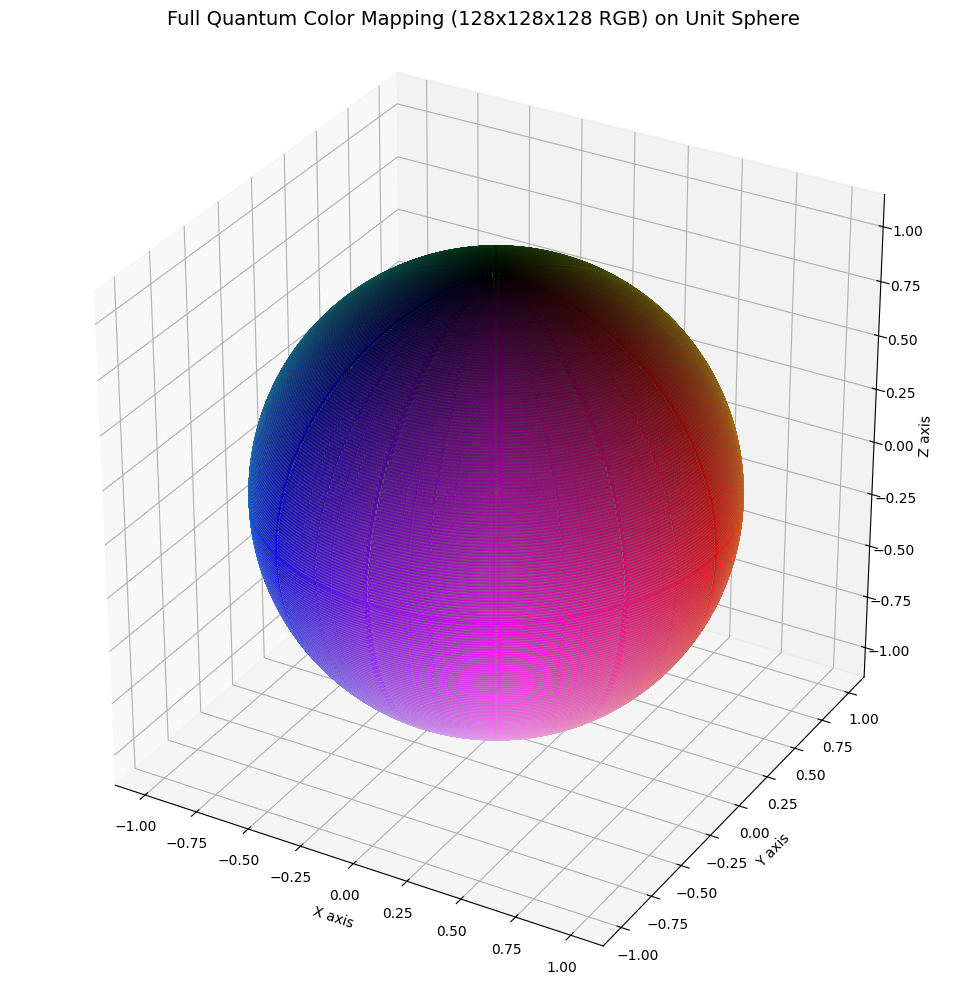

2097152

In [242]:
# Re-import after reset
import numpy as np
import matplotlib.pyplot as plt

# θ 계산 함수 (북반구/적도/남반구 식 적용)
def compute_theta(r, g, b):
    n = min(r, g, b)
    m = max(r, g, b)
    l = m + n

    if l < 127:  # 북반구
        a = 127 - l
        max_i = int(np.floor((127 - a) / 2))
        for i in range(max_i + 1):
            if m == 127 - a - i and n == i:
                return ((127 - a) * np.pi / 254) + (np.pi / 508) - ((np.pi / 254) * (i + 1) / (max_i + 1))

    elif l == 127:  # 적도
        max_i = int(np.floor(127 / 2))  # 63
        for i in range(max_i + 1):  # 0 ~ 63
            if m == 127 - i and n == i:
                if i == 0:
                    return np.pi / 2
                elif i != 0 and i % 2 == 0:  # 2,4,...,60, 62 
                    return np.pi / 2 + np.pi / 508 * i / 62
                elif i != 0 and i % 2 == 1:  # 1,3,...,61, 63
                    return np.pi / 2 - np.pi / 508 * (i + 1) / 64

    elif l > 127:  # 남반구
        a = l - 127
        max_i = int(np.floor((127 - a) / 2))
        for i in range(max_i + 1):
            if m == 127 - i and n == a + i:
                return ((127 + a) * np.pi / 254) - (np.pi / 508) + ((np.pi / 254) * (i + 1) / (max_i + 1))

    return l * np.pi / 254  # fallback

# RGB → θ, ϕ 변환
def rgb_to_theta_phi(r, g, b):
    n = min(r, g, b)
    m = max(r, g, b)
    l = m + n
    i = (r + g + b) - n - m

    theta = compute_theta(r, g, b)

    if m == n:
        phi = 0
    else:
        if r == m and b == n:
            k = i - b
            phi = (np.pi / 3) * k / (m - n)
        elif g == m and b == n:
            k = g - i
            phi = (np.pi / 3) * k / (m - n) + (np.pi / 3)
        elif g == m and r == n:
            k = i - r
            phi = (np.pi / 3) * k / (m - n) + (2 * np.pi / 3)
        elif b == m and r == n:
            k = b - i
            phi = (np.pi / 3) * k / (m - n) + (3 * np.pi / 3)
        elif b == m and g == n:
            k = i - g
            phi = (np.pi / 3) * k / (m - n) + (4 * np.pi / 3)
        elif r == m and g == n:
            k = r - i
            phi = (np.pi / 3) * k / (m - n) + (5 * np.pi / 3)
        else:
            phi = 0
    return theta, phi

# θ, ϕ → (x, y, z)
def theta_phi_to_xyz(theta, phi):
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    return x, y, z

# 전체 RGB 매핑
def map_full_rgb():
    global coords, colors, polar_coords
    coords = []
    colors = []
    polar_coords = []
    rep_values = [0] + [i for i in range(2, 254, 2)] + [254]  # 64개의 값

    for r in rep_values:
        for g in rep_values:
            for b in rep_values:
                # 양자화된 값 → 0~63 범위로 mapping (compute_theta가 기대하는 입력)
                r63, g63, b63 = r // 2, g // 2, b // 2

                theta, phi = rgb_to_theta_phi(r63, g63, b63)
                x, y, z = theta_phi_to_xyz(theta, phi)
                polar_coords.append((theta,phi))
                coords.append((x, y, z))
                colors.append((r / 255, g / 255, b / 255))  # for visual RGB color

    return np.array(coords), np.array(colors)


# 3D 시각화
def plot_full_quantum_color_sphere():
    coords, colors = map_full_rgb()
    x, y, z = coords[:, 0], coords[:, 1], coords[:, 2]

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c=colors, s=2)
    ax.set_title('Full Quantum Color Mapping (128x128x128 RGB) on Unit Sphere', fontsize=14)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_box_aspect([1, 1, 1])

    plt.tight_layout()
    plt.show()
    return len(colors)

# 실행
total_colors = plot_full_quantum_color_sphere()
total_colors

In [243]:
import numpy as np
import pandas as pd

# 예시 coords (theta, phi)와 color
# coords: N x 2 배열 (theta, phi), colors: N x 3 배열 (r,g,b)
# coords, colors는 이미 있다고 가정

# (1) theta, phi를 정렬된 배열로 가정
# 여기서는 예시용 placeholder (실제 실행 시 coords와 colors 대체 필요)
# coords = np.array([[...], [...], ...])
# colors = np.array([[...], [...], ...])

# (2) theta/phi 좌표 기준 정렬

polar_coords = np.array(polar_coords)  # 리스트 → NumPy 배열
colors = np.array(colors)
coords_sorted = polar_coords[np.lexsort((polar_coords[:, 1], polar_coords[:, 0]))]  # sort by theta then phi
theta_vals = np.unique(coords_sorted[:, 0])
phi_vals = np.unique(coords_sorted[:, 1])

# (3) 각 좌표를 (i,j) 그리드 인덱스로 변환
theta_to_idx = {val: idx for idx, val in enumerate(theta_vals)}
phi_to_idx = {val: idx for idx, val in enumerate(phi_vals)}

# (4) 각 좌표마다 theta_upper/lower, phi_left/right 계산
# 모든 row 계산
rows = []
for i in range(polar_coords.shape[0]):
    theta, phi = polar_coords[i]
    r, g, b = colors[i]
    ti = theta_to_idx[theta]
    pi = phi_to_idx[phi]

    theta_lower = theta_vals[ti - 1] if ti > 0 else theta
    theta_upper = theta_vals[ti + 1] if ti < len(theta_vals) - 1 else theta
    theta_lower = (theta + theta_lower) / 2
    theta_upper = (theta + theta_upper) / 2

    phi_left = phi_vals[pi - 1] if pi > 0 else phi
    phi_right = phi_vals[pi + 1] if pi < len(phi_vals) - 1 else phi
    phi_left = (phi + phi_left) / 2
    phi_right = (phi + phi_right) / 2

    rows.append({
        'r': int(r * 255),
        'g': int(g * 255),
        'b': int(b * 255),
        'theta': theta,
        'phi': phi,
        'theta_lower': theta_lower,
        'theta_upper': theta_upper,
        'phi_left': phi_left,
        'phi_right': phi_right
    })

# DataFrame 생성
df = pd.DataFrame(rows)

# (6) 나누어 저장
num_splits = 4
chunk_size = math.ceil(len(df) / num_splits)

paths = []
for i in range(num_splits):
    chunk_df = df[i * chunk_size: (i + 1) * chunk_size]
    path = f"{i+1}th 128 coords_with_bounds.csv"
    chunk_df.to_csv(path, index=False)
    paths.append(path)

paths

['1th 128 coords_with_bounds.csv',
 '2th 128 coords_with_bounds.csv',
 '3th 128 coords_with_bounds.csv',
 '4th 128 coords_with_bounds.csv']

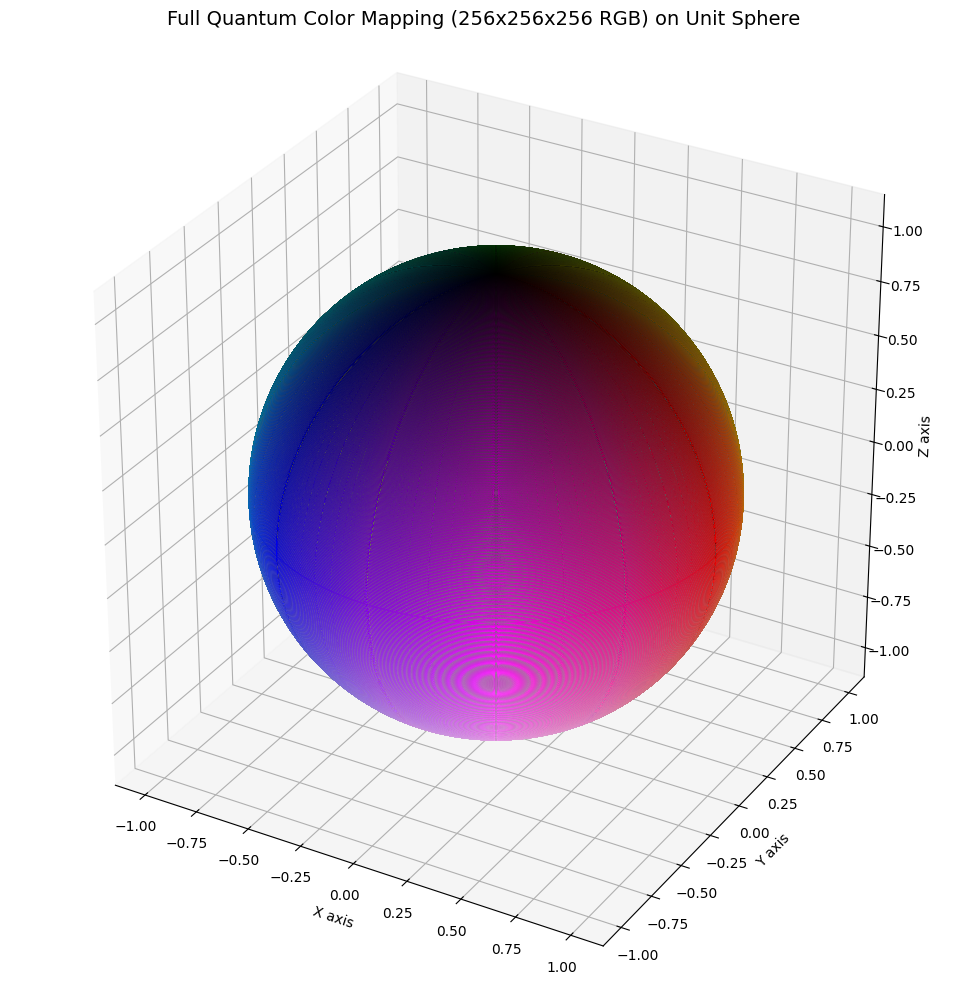

16777216

In [244]:
# Re-import after reset
import numpy as np
import matplotlib.pyplot as plt

# θ 계산 함수 (북반구/적도/남반구 식 적용)
def compute_theta(r, g, b):
    n = min(r, g, b)
    m = max(r, g, b)
    l = m + n

    if l < 255:  # 북반구
        a = 255 - l
        max_i = int(np.floor((255 - a) / 2))
        for i in range(max_i + 1):
            if m == 255 - a - i and n == i:
                return ((255 - a) * np.pi / 510) + (np.pi / 1020) - ((np.pi / 510) * (i + 1) / (max_i + 1))

    elif l == 255:  # 적도
        max_i = int(np.floor(255 / 2))  # 127
        for i in range(max_i + 1):  # 0 ~ 127
            if m == 255 - i and n == i:
                if i == 0:
                    return np.pi / 2
                elif i != 0 and i % 2 == 0:  # 2,4,...,124, 126 
                    return np.pi / 2 + np.pi / 1020 * i / 126
                elif i != 0 and i % 2 == 1:  # 1,3,...,125, 127
                    return np.pi / 2 - np.pi / 1020 * (i + 1) / 128

    elif l > 255:  # 남반구
        a = l - 255
        max_i = int(np.floor((255 - a) / 2))
        for i in range(max_i + 1):
            if m == 255 - i and n == a + i:
                return ((255 + a) * np.pi / 510) - (np.pi / 1020) + ((np.pi / 510) * (i + 1) / (max_i + 1))

    return l * np.pi / 510  # fallback

# RGB → θ, ϕ 변환
def rgb_to_theta_phi(r, g, b):
    n = min(r, g, b)
    m = max(r, g, b)
    l = m + n
    i = (r + g + b) - n - m

    theta = compute_theta(r, g, b)

    if m == n:
        phi = 0
    else:
        if r == m and b == n:
            k = i - b
            phi = (np.pi / 3) * k / (m - n)
        elif g == m and b == n:
            k = g - i
            phi = (np.pi / 3) * k / (m - n) + (np.pi / 3)
        elif g == m and r == n:
            k = i - r
            phi = (np.pi / 3) * k / (m - n) + (2 * np.pi / 3)
        elif b == m and r == n:
            k = b - i
            phi = (np.pi / 3) * k / (m - n) + (3 * np.pi / 3)
        elif b == m and g == n:
            k = i - g
            phi = (np.pi / 3) * k / (m - n) + (4 * np.pi / 3)
        elif r == m and g == n:
            k = r - i
            phi = (np.pi / 3) * k / (m - n) + (5 * np.pi / 3)
        else:
            phi = 0
    return theta, phi

# θ, ϕ → (x, y, z)
def theta_phi_to_xyz(theta, phi):
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    return x, y, z

# 전체 RGB 매핑
def map_full_rgb():
    global coords, colors, polar_coords
    coords = []
    colors = []
    polar_coords = []
    rep_values = [0] + [i for i in range(1, 255)] + [255]  # 64개의 값

    for r in rep_values:
        for g in rep_values:
            for b in rep_values:
                # 양자화된 값 → 0~63 범위로 mapping (compute_theta가 기대하는 입력)
                r63, g63, b63 = r, g, b

                theta, phi = rgb_to_theta_phi(r63, g63, b63)
                x, y, z = theta_phi_to_xyz(theta, phi)
                polar_coords.append((theta,phi))
                coords.append((x, y, z))
                colors.append((r / 255, g / 255, b / 255))  # for visual RGB color

    return np.array(coords), np.array(colors)

# 3D 시각화
def plot_full_quantum_color_sphere():
    coords, colors = map_full_rgb()
    x, y, z = coords[:, 0], coords[:, 1], coords[:, 2]

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c=colors, s=2)
    ax.set_title('Full Quantum Color Mapping (256x256x256 RGB) on Unit Sphere', fontsize=14)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_box_aspect([1, 1, 1])

    plt.tight_layout()
    plt.show()
    return len(colors)

# 실행
total_colors = plot_full_quantum_color_sphere()
total_colors

In [245]:
import numpy as np
import pandas as pd

# 예시 coords (theta, phi)와 color
# coords: N x 2 배열 (theta, phi), colors: N x 3 배열 (r,g,b)
# coords, colors는 이미 있다고 가정

# (1) theta, phi를 정렬된 배열로 가정
# 여기서는 예시용 placeholder (실제 실행 시 coords와 colors 대체 필요)
# coords = np.array([[...], [...], ...])
# colors = np.array([[...], [...], ...])

# (2) theta/phi 좌표 기준 정렬

polar_coords = np.array(polar_coords)  # 리스트 → NumPy 배열
colors = np.array(colors)
coords_sorted = polar_coords[np.lexsort((polar_coords[:, 1], polar_coords[:, 0]))]  # sort by theta then phi
theta_vals = np.unique(coords_sorted[:, 0])
phi_vals = np.unique(coords_sorted[:, 1])

# (3) 각 좌표를 (i,j) 그리드 인덱스로 변환
theta_to_idx = {val: idx for idx, val in enumerate(theta_vals)}
phi_to_idx = {val: idx for idx, val in enumerate(phi_vals)}

# (4) 각 좌표마다 theta_upper/lower, phi_left/right 계산
# 모든 row 계산
rows = []
for i in range(polar_coords.shape[0]):
    theta, phi = polar_coords[i]
    r, g, b = colors[i]
    ti = theta_to_idx[theta]
    pi = phi_to_idx[phi]

    theta_lower = theta_vals[ti - 1] if ti > 0 else theta
    theta_upper = theta_vals[ti + 1] if ti < len(theta_vals) - 1 else theta
    theta_lower = (theta + theta_lower) / 2
    theta_upper = (theta + theta_upper) / 2

    phi_left = phi_vals[pi - 1] if pi > 0 else phi
    phi_right = phi_vals[pi + 1] if pi < len(phi_vals) - 1 else phi
    phi_left = (phi + phi_left) / 2
    phi_right = (phi + phi_right) / 2

    rows.append({
        'r': int(r * 255),
        'g': int(g * 255),
        'b': int(b * 255),
        'theta': theta,
        'phi': phi,
        'theta_lower': theta_lower,
        'theta_upper': theta_upper,
        'phi_left': phi_left,
        'phi_right': phi_right
    })

# DataFrame 생성
df = pd.DataFrame(rows)

# (6) 나누어 저장
num_splits = 32
chunk_size = math.ceil(len(df) / num_splits)

paths = []
for i in range(num_splits):
    chunk_df = df[i * chunk_size: (i + 1) * chunk_size]
    path = f"{i+1}th 256 coords_with_bounds.csv"
    chunk_df.to_csv(path, index=False)
    paths.append(path)

paths

['1th 256 coords_with_bounds.csv',
 '2th 256 coords_with_bounds.csv',
 '3th 256 coords_with_bounds.csv',
 '4th 256 coords_with_bounds.csv',
 '5th 256 coords_with_bounds.csv',
 '6th 256 coords_with_bounds.csv',
 '7th 256 coords_with_bounds.csv',
 '8th 256 coords_with_bounds.csv',
 '9th 256 coords_with_bounds.csv',
 '10th 256 coords_with_bounds.csv',
 '11th 256 coords_with_bounds.csv',
 '12th 256 coords_with_bounds.csv',
 '13th 256 coords_with_bounds.csv',
 '14th 256 coords_with_bounds.csv',
 '15th 256 coords_with_bounds.csv',
 '16th 256 coords_with_bounds.csv',
 '17th 256 coords_with_bounds.csv',
 '18th 256 coords_with_bounds.csv',
 '19th 256 coords_with_bounds.csv',
 '20th 256 coords_with_bounds.csv',
 '21th 256 coords_with_bounds.csv',
 '22th 256 coords_with_bounds.csv',
 '23th 256 coords_with_bounds.csv',
 '24th 256 coords_with_bounds.csv',
 '25th 256 coords_with_bounds.csv',
 '26th 256 coords_with_bounds.csv',
 '27th 256 coords_with_bounds.csv',
 '28th 256 coords_with_bounds.csv',
 

In [273]:
import pandas as pd

def find_matching_rgb(theta_prime, phi_prime, lut_path="64\\64 RGB coords_with_bounds.csv"):
    # 엑셀 로드
    df = pd.read_csv(lut_path)

    # 1차 필터링: θ 범위 내에 있는 행 추출
    theta_filtered = df[(df['theta_lower'] <= theta_prime) & (df['theta_upper'] >= theta_prime)]
    #print(theta_filtered)
    # 2차 필터링: ϕ 범위 내에 있는 행 추출
    phi_filtered = theta_filtered[(theta_filtered['phi_left'] <= phi_prime) & (theta_filtered['phi_right'] >= phi_prime)]

    return phi_filtered[['r', 'g', 'b', 'theta', 'phi', 'theta_lower', 'theta_upper', 'phi_left', 'phi_right']]

In [298]:
theta_prime = np.random.uniform(0, np.pi)
phi_prime = np.random.uniform(0, 2 * np.pi)
print("theta prime = ", theta_prime, "phi prime = ",phi_prime)
find_matching_rgb(theta_prime, phi_prime)

theta prime =  0.5283842051731719 phi prime =  4.601631466523352


Empty DataFrame
Columns: [r, g, b, theta, phi, theta_lower, theta_upper, phi_left, phi_right]
Index: []

# Test

In [73]:
# RGB = (20,30,40) 
# theta = 1.49157285613985, phi = 3.66519142918809
theta = 1.49157285613985
phi = 3.66519142918809
start = time.time()


phis = []

for i in range(1):
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis.append(phi)
    else:
        phi = round(phi/4,4)
        phis.append(phi)

thetas = []
for i in range(1):
    thetas.append(theta)

w_bits = int(np.ceil(1))
h_bits = int(np.ceil(1))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

num_ind_bits = int(h_bits + w_bits)

if not num_ind_bits:
    num_ind_bits = 1

O = QuantumRegister(2, 'q1')
c = QuantumRegister(1,'q0')
p = QuantumRegister(1, 'q2')
cr = ClassicalRegister(O.size+c.size+p.size, "cl")

qc_image = QuantumCircuit(c,O,p, cr)

qc_image.id(c)
qc_image.h(O)
qc_image.h(p)

qc_image.barrier()
controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind): 
            qc_image.barrier()
            qc_image.x(O[k])
            

    
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()

        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0],)

            qc_image.barrier()
            if i!=len(thetas) - 1:
                qc_image.x(p)
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])
           

qc_image.x(p)
qc_image.x(O)
statevec_qc = Statevector(qc_image)
qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc_image, aer_sim)
result = aer_sim.run(t_qc_image, shots=100000).result()
counts = result.get_counts()

pixel_theta_recon = []
pixel_phi_recon = []

pixel_theta = []
pixel_phi = []

for i in range(2):
    for item in counts.items():
        key = item[0]
        amount = item[1]
        state = key[0]
        decision = int(key[-1])
        bin_coord = key[1:-1]
        int_coord = int(bin_coord, 2)
        if int_coord == i and decision == 1:
            pixel_theta.append((state,bin_coord, amount))
        elif int_coord == i and decision == 0:
            pixel_phi.append((state,bin_coord, amount))

# ======================== phi ====================================
phi_result_dict = {}
for state in pixel_phi:
    key = state[1]
    value = state[2] 
    if key in phi_result_dict:
        phi_result_dict[key] += value  
    else:
        phi_result_dict[key] = value  

phi_result_list = [(key, value) for key, value in phi_result_dict.items()]
#print(phi_result_list)

phi_state_0 = []
for state, phi, amount in pixel_phi:
    if not int(state):
        phi_state_0.append((phi, amount))

for i in range(2):
    try:
        phi = np.arccos((phi_state_0[i][1]/phi_result_list[i][1])**(1/2))
        pixel_phi_recon.append(phi*4)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================
        
theta_result_dict = {}
for state in pixel_theta:
    key = state[1]
    value = state[2] 
    if key in theta_result_dict:
        theta_result_dict[key] += value  
    else:
        theta_result_dict[key] = value  

theta_result_list = [(key, value) for key, value in theta_result_dict.items()]

theta_state_0 = []

for state, theta, amount in pixel_theta:
    if not int(state):
        theta_state_0.append((theta, amount))

for i in range(2):
    try:
        theta = np.arccos((theta_state_0[i][1]/theta_result_list[i][1])**(1/2))
        pixel_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

print(pixel_theta_recon, pixel_phi_recon)
print(thetas[0]*2, phis[0]*4)

theta_prime = pixel_theta_recon[0]*0.5
phi_prime = pixel_phi_recon[0]
find_matching_rgb(theta_prime, phi_prime, lut_path="LUT_theta_phi_bounds.csv")

[2.983224564467907, 0.0] [3.6776276834363673, 0.0]
2.9831457122797 3.6652


r   g   b  theta_start     theta  theta_end  phi_start       phi  \
83880  20  30  40     1.491171  1.491573   1.491975   3.639011  3.665191   

        phi_end  
83880  3.691371

In [ ]:
import cv2

airplane = cv2.imread("airplane1.png")

# LUT 로드 및 θ, φ 추출
lut_df = pd.read_csv("LUT_theta_phi_bounds.csv")
lut_dict = {(row.r, row.g, row.b): (row.theta, row.phi) for row in lut_df.itertuples()}

def get_theta_phi_from_image_lut(image_rgb_array, lut_dict):
    height, width, _ = image_rgb_array.shape
    theta_map = np.zeros((height, width))
    phi_map = np.zeros((height, width))

    for i in range(height):
        for j in range(width):
            r63, g63, b63 = (image_rgb_array[i, j]/255 * 63).astype(int)
            theta, phi = lut_dict.get((r63, g63, b63), (0, 0))
            theta_map[i, j] = theta
            phi_map[i, j] = phi

    return theta_map, phi_map

theta_map, phi_map = get_theta_phi_from_image_lut(airplane, lut_dict)
theta_map, phi_map


In [170]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def quantize_rgb_image(image_path):
    # 1. 이미지 로드
    img = cv2.imread(image_path)  # BGR로 읽힘
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # RGB로 변환

    # 2. 4단위 quantization 수행 (0~255 → 0, 4, 8, ..., 252)
    quantized_img = (img // 4) * 4

    return img, quantized_img

def visualize_original_and_quantized(original_img, quantized_img):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title("Original RGB Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(quantized_img)
    plt.title("Quantized RGB Image (4-unit)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

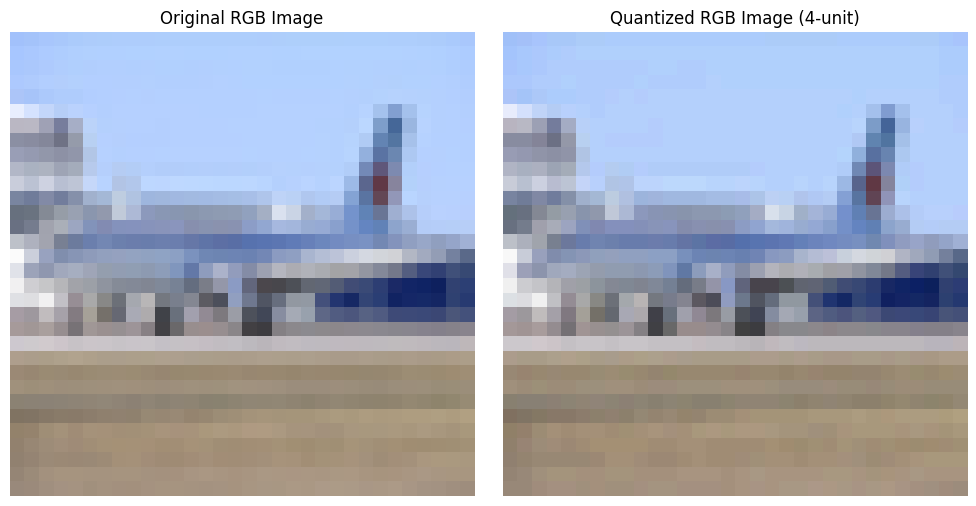

In [171]:
# 실행
original, quantized = quantize_rgb_image("airplane1.png")
visualize_original_and_quantized(original, quantized)


In [48]:
theta_map_flat = theta_map.flatten()
phi_map_flat = phi_map.flatten()

In [64]:
for i in range(5):
    print((airplane[0][i] /255 * 63).astype(int))
    print(find_matching_rgb(theta_map_flat[i], phi_map_flat[i], lut_path="LUT_theta_phi_bounds.csv"))
    print("===================================================================")

[62 47 40]
         r   g   b  theta_start     theta  theta_end  phi_start       phi  \
257000  62  47  40     2.533604  2.534563   2.535522   0.309399  0.333199   

         phi_end  
257000  0.356999  
[61 48 40]
         r   g   b  theta_start     theta  theta_end  phi_start       phi  \
252968  61  48  40     2.510589  2.511548   2.512507   0.373999  0.398932   

         phi_end  
252968  0.423866  
[62 48 41]
         r   g   b  theta_start     theta  theta_end  phi_start       phi  \
257065  62  48  41     2.558777  2.559816   2.560855   0.324133  0.349066   

         phi_end  
257065  0.373999  
[62 49 41]
         r   g   b  theta_start     theta  theta_end  phi_start       phi  \
257129  62  49  41     2.558777  2.559816   2.560855   0.373999  0.398932   

         phi_end  
257129  0.423866  
[62 50 42]
         r   g   b  theta_start    theta  theta_end  phi_start       phi  \
257194  62  50  42     2.583711  2.58475   2.585788   0.392699  0.418879   

         phi_end  
2

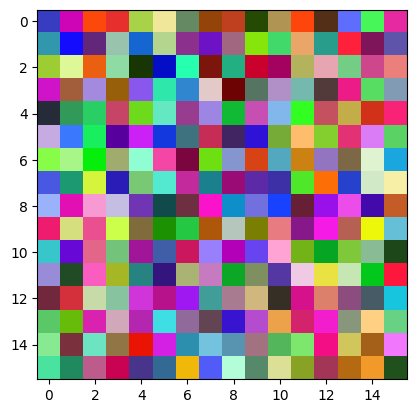

In [232]:
image = np.random.randint(0, 256, size=(16, 16, 3), dtype=np.uint8)

plt.imshow(image, cmap = 'gray')

In [ ]:
radius = []
k_list = []
size_list = []
def project(img, n):
    global radius
    (row, col, _) = img
    x = row
    y = col
    z = 0
    r = round(np.sqrt(2**(2*n)/(8 * np.pi)),4)
    radius.append(r)
    Q = np.array([x, y, z], dtype=np.float32)
    X = get_2d_to_3d(Q,r)
    return X

def get_2d_to_3d(point,r):
    global size_list, k_list
    [x, y, _] = point
    k = round(4*r**2 / (x**2 + y**2 + 4*r**2), 4)
    P = np.array([k * x, k * y, (1-2*k)*r ])
    size = np.sqrt(P[0]**2+P[1]**2+P[2]**2)
    resize = P*(1/size)
    k = k * (1/size)
    size_list.append(size)
    k_list.append(k)
    return resize

def generate_coordinates(input_tuple):
    # 입력된 튜플의 값을 2로 나눔
    x, y = input_tuple
    x /= 2
    y /= 2

    # 좌표 리스트 초기화
    coordinates = []

    # 음수부터 양수까지 좌표 생성
    for i in range(-int(x), int(x) + 1):
        for j in range(-int(x), int(y) + 1):
            if i != 0 and j != 0:
                # z 값은 항상 0
                coordinates.append(np.array([i, j, 0]))
    return coordinates

def generate_normal_coordinates(input_tuple):
    # 입력된 튜플의 값을 2로 나눔
    x, y = input_tuple
    x /= 2
    y /= 2

    # 좌표 리스트 초기화
    coordinates = []

    # 양수 값 좌표만 생성
    for i in range(0, 2 * int(x) + 1):
        for j in range(0, 2 * int(y) + 1):
            if i != 0 and j != 0:
                # z 값은 항상 0
                coordinates.append(np.array([i, j, 0]))
    return coordinates

def y_axis_reflection(point):
    return np.array([-point[0], point[1], point[2]])

def x_axis_reflection(point):
    return np.array([point[0], -point[1], point[2]])

def origin_reflection(point):
    return np.array([-point[0], -point[1], point[2]])

[array([0.3753181 , 0.36284532, 0.85292415]), array([0.41681123, 0.34977018, 0.8390049 ]), array([0.41954489, 0.37453925, 0.82686301]), array([0.42980517, 0.3646472 , 0.82601449]), array([0.4576978 , 0.34645856, 0.81882794]), array([0.49383952, 0.32973229, 0.80461118]), array([0.52113192, 0.31912214, 0.79156969]), array([0.54199028, 0.30907029, 0.7814871 ]), array([0.57036065, 0.27851007, 0.77273596]), array([0.59482163, 0.26783623, 0.75792545]), array([0.61142174, 0.23000809, 0.75713918]), array([0.64555344, 0.20685013, 0.73516922]), array([0.64742497, 0.17715852, 0.74125284]), array([0.67242586, 0.13550685, 0.7276547 ]), array([0.68284483, 0.08772396, 0.7252775 ]), array([0.69145919, 0.05417997, 0.72038095]), array([0.37239991, 0.38963395, 0.84232042]), array([0.39280316, 0.40120972, 0.82748803]), array([0.41587318, 0.40021257, 0.81662684]), array([0.43671744, 0.38789452, 0.81167464]), array([0.47709993, 0.35301173, 0.80483438]), array([0.50196593, 0.35894087, 0.78688732]), array([0.

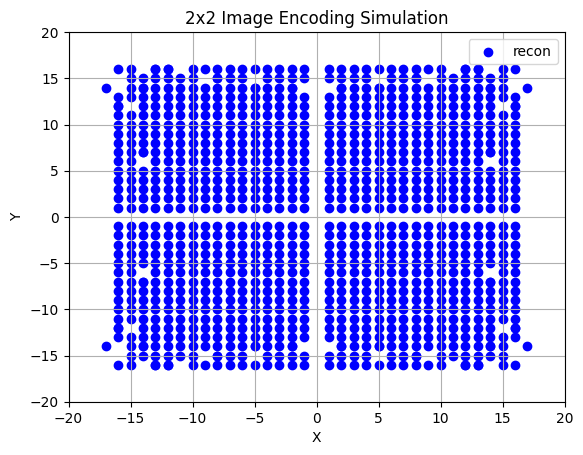

0.04296875


In [234]:
start = time.time()

img_mean  = np.mean(image, axis=2, dtype=np.uint8)
input_tuple = img_mean.shape
Q = generate_normal_coordinates(input_tuple)
n = int(np.ceil(math.log(input_tuple[0], 2)))

P = []
radius = []
k_list = []
size_list = []
for i in range(len(Q)):
  sphere = project(Q[i], n)
  P.append(sphere)

phis = []
for i in range(len(P)):
    phi = round(np.arctan2(P[i][1], P[i][0]),4)
    if phi <0:
        phi = round((6.283-abs(phi))/4,4)
        phis.append(phi)
    else:
        phi = round(phi/4,4)
        phis.append(phi)

thetas = []
for i in range(len(P)):
    theta = round(np.arccos(P[i][2])/2,4)
    thetas.append(theta)

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

num_ind_bits = int(h_bits + w_bits)

if not num_ind_bits:
    num_ind_bits = 1

O = QuantumRegister(w_bits+h_bits, 'q1')
c = QuantumRegister(1,'q0')
p = QuantumRegister(1, 'q2')
cr = ClassicalRegister(O.size+c.size+p.size, "cl")

qc_image = QuantumCircuit(c,O,p, cr)

qc_image.id(c)
qc_image.h(O)
qc_image.h(p)

qc_image.barrier()
controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind): 
            qc_image.barrier()
            qc_image.x(O[k])
            

    
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()

        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0],)

            qc_image.barrier()
            if i!=len(thetas) - 1:
                qc_image.x(p)
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])
           

qc_image.x(p)
qc_image.x(O)
statevec_qc = Statevector(qc_image)
qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc_image, aer_sim)
result = aer_sim.run(t_qc_image, shots=8000000).result()
counts = result.get_counts()

pixel_theta_recon = []
pixel_phi_recon = []

pixel_theta = []
pixel_phi = []

for i in range(0, len(P)):
    for item in counts.items():
        key = item[0]
        amount = item[1]
        state = key[0]
        decision = int(key[-1])
        bin_coord = key[1:-1]
        int_coord = int(bin_coord, 2)
        if int_coord == i and decision == 1:
            pixel_theta.append((state,bin_coord, amount))
        elif int_coord == i and decision == 0:
            pixel_phi.append((state,bin_coord, amount))

# ======================== phi ====================================
phi_result_dict = {}
for state in pixel_phi:
    key = state[1]
    value = state[2] 
    if key in phi_result_dict:
        phi_result_dict[key] += value  
    else:
        phi_result_dict[key] = value  

phi_result_list = [(key, value) for key, value in phi_result_dict.items()]
#print(phi_result_list)

phi_state_0 = []
for state, phi, amount in pixel_phi:
    if not int(state):
        phi_state_0.append((phi, amount))

for i in range(0, len(P)):
    try:
        phi = np.arccos((phi_state_0[i][1]/phi_result_list[i][1])**(1/2))
        pixel_phi_recon.append(phi*4)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================
        
theta_result_dict = {}
for state in pixel_theta:
    key = state[1]
    value = state[2] 
    if key in theta_result_dict:
        theta_result_dict[key] += value  
    else:
        theta_result_dict[key] = value  

theta_result_list = [(key, value) for key, value in theta_result_dict.items()]

theta_state_0 = []

for state, theta, amount in pixel_theta:
    if not int(state):
        theta_state_0.append((theta, amount))

for i in range(0, len(P)):
    try:
        theta = np.arccos((theta_state_0[i][1]/theta_result_list[i][1])**(1/2))
        pixel_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")

recon_pixel = []
for i in range(len(P)):
    x = np.cos(pixel_phi_recon[i]) * np.sin(pixel_theta_recon[i])
    y = np.sin(pixel_phi_recon[i]) * np.sin(pixel_theta_recon[i])
    z = np.cos(pixel_theta_recon[i])
    recon_pixel.append(np.array([x,y,z]))
print(recon_pixel)
back_recon_pixel= []
for i in range(len(P)):
    k = 0.5 * (1 - recon_pixel[i][2] * size_list[i] / radius[0])
    k = k / size_list[i]
    X = np.round(recon_pixel[i][0] / k)
    Y = np.round(recon_pixel[i][1] / k)
    back_P = np.array([X,Y,0])
    back_recon_pixel.append(back_P)
back_recon_pixel = list(reversed(back_recon_pixel))
print("reconstructed pixel  =",back_recon_pixel)
end = time.time()
print(f"{end - start:.5f} sec")

back_2 = [y_axis_reflection(point) for point in back_recon_pixel]
back_3 = [origin_reflection(point) for point in back_recon_pixel]
back_4 = [x_axis_reflection(point) for point in back_recon_pixel]

x_values = [point[0] for point in back_recon_pixel]
y_values = [point[1] for point in back_recon_pixel]

x_2 = [point[0] for point in back_2]
y_2 = [point[1] for point in back_2]

x_3 = [point[0] for point in back_3]
y_3 = [point[1] for point in back_3]

x_4 = [point[0] for point in back_4]
y_4 = [point[1] for point in back_4]

x_Q = [point[0] for point in Q]
y_Q = [point[1] for point in Q]


origin_image = np.random.uniform(low=0,high=255, size=(2**(n+1),2**(n+1),3)).astype(int)

origin_img_mean  = np.mean(origin_image, axis=2, dtype=np.uint8)
origin_input_tuple = origin_img_mean.shape
Q_origin = generate_coordinates(origin_input_tuple)

x_Q_origin = [point[0] for point in Q_origin]
y_Q_origin = [point[1] for point in Q_origin]

# 시각화
plt.scatter(x_values, y_values, color='blue', label='recon')
plt.scatter(x_2, y_2, color='blue')
plt.scatter(x_3, y_3, color='blue')
plt.scatter(x_4, y_4, color='blue')
#plt.scatter(x_Q_origin, y_Q_origin, color='gray', label = 'classical')
plt.title('2x2 Image Encoding Simulation')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(-20,20)
plt.ylim(-20,20)
plt.legend()
plt.grid(True)
plt.show()

error = []
for i in range(len(Q)):
    del_x = x_Q[i] - x_values[i]
    del_y = y_Q[i] - y_values[i]
    err = del_x**2+del_y**2
    error.append(err)

MSE = sum(error)/len(Q) 
print(MSE)

In [235]:
position = back_2  + back_recon_pixel + back_3 + back_4
# (1) 앞 2개 값만 추출
xy = np.round(np.array([arr[:2] for arr in position])).astype(int)  # shape (N, 2)

# (2) 정렬: y 내림차순, x 오름차순
sorted_indices = np.lexsort((xy[:, 0], -xy[:, 1]))  # x 오름차순, y 내림차순

# (3) 정렬된 좌표
xy_sorted = xy[sorted_indices]

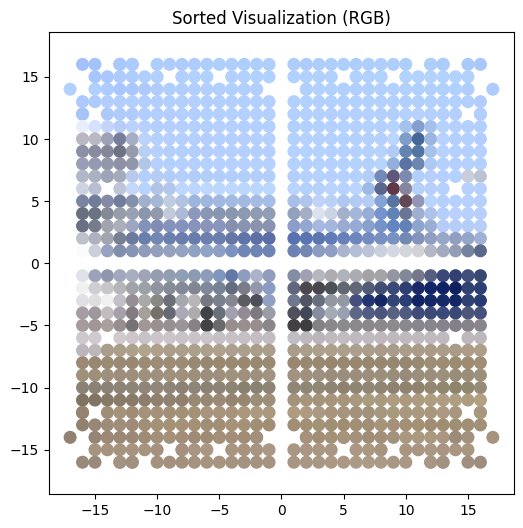

In [245]:
airplane = cv2.imread("airplane1.png")
airplane_rgb = cv2.cvtColor(airplane, cv2.COLOR_BGR2RGB)
airplane_flat = airplane_rgb.flatten()

# airplane_flat shape: (1024, 3) ← RGB 3채널로 reshape 필요
colors = airplane_flat.reshape(-1, 3) / 255  # 정규화 필요

plt.figure(figsize=(6, 6))
scatter = plt.scatter(xy_sorted[:, 0], xy_sorted[:, 1], 
                      c=colors, s=70)
plt.axis('equal')
plt.title('Sorted Visualization (RGB)')
plt.show()


In [246]:
import numpy as np

# (1) 복사본 생성 (수정용)
xy_shifted = xy_sorted.copy()

# (2) x, y 추출
x = xy_shifted[:, 0]
y = xy_shifted[:, 1]

# (3) 사분면별 마스크 정의
mask_q2 = (x < 0) & (y >= 0)
mask_q3 = (x < 0) & (y < 0)
mask_q4 = (x >= 0) & (y < 0)

# (4) 평행이동 적용
xy_shifted[mask_q2, 0] += 1            # Q2: x += 1
xy_shifted[mask_q3, 0] += 1            # Q3: x += 1
xy_shifted[mask_q3, 1] += 1            # Q3: y += 1
xy_shifted[mask_q4, 1] += 1            # Q4: y += 1

# ✅ 결과: xy_shifted에는 이동된 좌표들이 들어있습니다

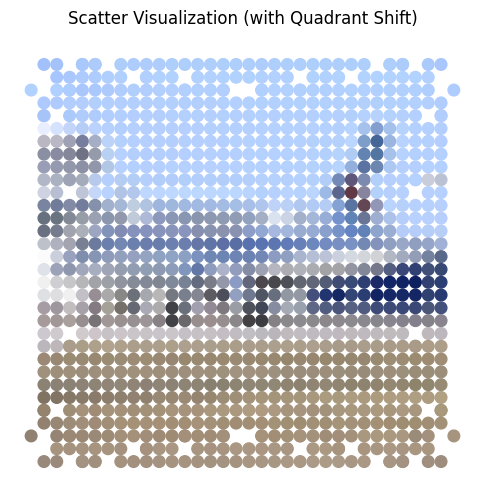

In [247]:
import matplotlib.pyplot as plt

# (1) x, y 좌표와 grayscale 값 준비
x = xy_shifted[:, 0]
y = xy_shifted[:, 1]

colors = airplane_flat.reshape(-1, 3) / 255
# (2) 시각화
plt.figure(figsize=(6, 6))
plt.scatter(x, y, c= colors, s=70)
plt.axis('equal')
plt.axis('off')
plt.title('Scatter Visualization (with Quadrant Shift)')
plt.show()


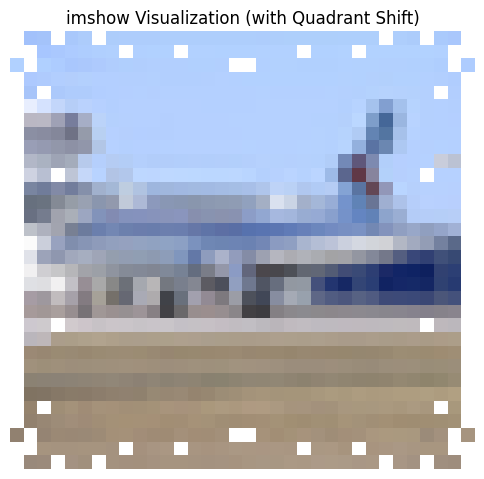

In [248]:
import numpy as np

# (1) 전체 좌표 범위 계산
x_min, x_max = x.min(), x.max()
y_min, y_max = y.min(), y.max()

width = x_max - x_min + 1
height = y_max - y_min + 1

# (2) 이미지 초기화 (빈 공간은 NaN)
recon_image = np.full((height, width, 3), np.nan)

# (3) 각 좌표를 이미지 배열에 매핑
for xi, yi, g in zip(x, y, colors):
    col = int(xi - x_min)           # x → column
    row = int(y_max - yi)           # y → row (영상 좌표계: 위가 0)
    recon_image[row, col] = g

# (4) 시각화
plt.figure(figsize=(6, 6))
plt.imshow(recon_image, vmin=0, vmax=255, interpolation='nearest')
plt.axis('off')
plt.title('imshow Visualization (with Quadrant Shift)')
plt.show()

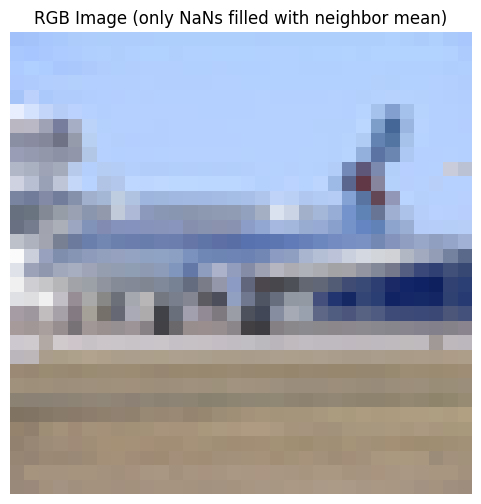

In [249]:
import numpy as np
from scipy.ndimage import generic_filter

def fill_nan_with_neighbor_avg(channel):
    """NaN을 인접 평균으로 대체한 채널 반환"""
    def nanmean_filter(values):
        values = values[~np.isnan(values)]
        return np.mean(values) if values.size > 0 else np.nan

    # 전체 채널에 대해 보간
    interpolated = generic_filter(channel, function=nanmean_filter, size=3, mode='constant', cval=np.nan)
    
    # NaN 위치만 업데이트
    filled = channel.copy()
    mask = np.isnan(channel)
    filled[mask] = interpolated[mask]
    
    return filled

image_filled = np.zeros_like(image)

for c in range(3):  # R, G, B 채널
    image_filled[:, :, c] = fill_nan_with_neighbor_avg(image[:, :, c])

cropped_image = image_filled[:,1:-1]
plt.figure(figsize=(6, 6))
plt.imshow(cropped_image)
plt.axis('off')
plt.title('RGB Image (only NaNs filled with neighbor mean)')
plt.show()


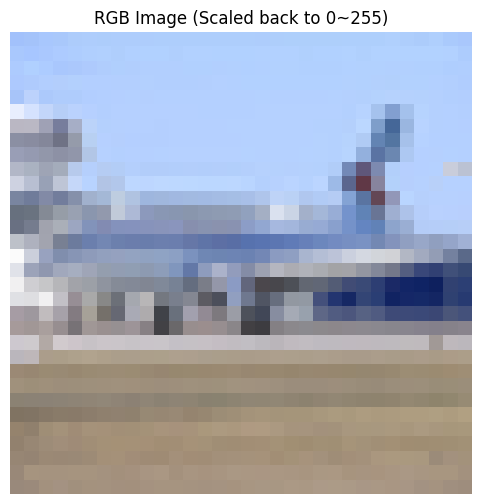

In [264]:
# (1) 0~1 범위를 0~255 범위로 스케일링
image_filled_uint8 = np.clip(image_filled * 255, 0, 255).astype(np.uint8)

# (2) 크롭 후 시각화
cropped_image = image_filled_uint8[:, 1:-1]

plt.figure(figsize=(6, 6))
plt.imshow(cropped_image)
plt.axis('off')
plt.title('RGB Image (Scaled back to 0~255)')
plt.show()


In [270]:
# (1) 두 이미지 준비 (float 형태로 변환)
original = airplane.astype(float)
reconstructed = cropped_image.astype(float)

# (2) 오차 계산
error_array = np.abs(original - reconstructed)

# (3) 픽셀 좌표 + 값 기록
records = []

for y in range(28):
    for x in range(28):
        err = error_array[y, x]  # shape: (3,)
        if np.any(err > 0):  # 또는 np.linalg.norm(err) > 0
            records.append({
                'x': x,
                'y': y,
                'original_rgb': original[y, x],
                'reconstructed_rgb': reconstructed[y, x],
                'error_rgb': err,
                'error_magnitude': np.linalg.norm(err)
            })

df_error = pd.DataFrame(records)
df_error_sorted = df_error.sort_values(by='error_magnitude', ascending=False)
df_error_sorted


x   y           original_rgb      reconstructed_rgb  \
303  23  10  [231.0, 186.0, 157.0]   [91.0, 102.0, 142.0]   
275  23   9  [248.0, 205.0, 177.0]  [115.0, 137.0, 183.0]   
278  26   9  [176.0, 138.0, 125.0]  [178.0, 207.0, 250.0]   
306  26  10  [157.0, 132.0, 135.0]  [179.0, 209.0, 250.0]   
388  24  13  [193.0, 133.0, 100.0]  [100.0, 133.0, 193.0]   
..   ..  ..                    ...                    ...   
602  22  21  [191.0, 185.0, 191.0]  [190.0, 186.0, 191.0]   
603  23  21  [190.0, 185.0, 191.0]  [191.0, 185.0, 191.0]   
589   9  21  [201.0, 197.0, 201.0]  [201.0, 196.0, 201.0]   
605  25  21  [190.0, 186.0, 190.0]  [190.0, 185.0, 190.0]   
604  24  21  [190.0, 185.0, 190.0]  [191.0, 185.0, 190.0]   

               error_rgb  error_magnitude  
303  [140.0, 84.0, 15.0]       163.954262  
275   [133.0, 68.0, 6.0]       149.495819  
278   [2.0, 69.0, 125.0]       142.793557  
306  [22.0, 77.0, 115.0]       140.135649  
388    [93.0, 0.0, 93.0]       131.521861  
..                   ...              ...  
602      [1.0, 1.0, 0.0]         1.414214  
603      [1.0, 0.0, 0.0]         1.000000  
589      [0.0, 1.0, 0.0]         1.000000  
605      [0.0, 1.0, 0.0]         1.000000  
604      [1.0, 0.0, 0.0]         1.000000  

[776 rows x 6 columns]

# Airplane with color space

In [ ]:
def fill_missing_theta_for_state_0(pixel_theta):
    # (1) 모든 가능한 theta 10bit 문자열
    all_theta = {format(i, '010b') for i in range(1024)}

    # (2) 기존 pixel_theta 중 state가 '0'인 것만 필터링
    state_0_entries = [(state, theta, amount) for state, theta, amount in pixel_theta if state == '0']

    # (3) 존재하는 theta 추출
    existing_theta_0 = {theta for state, theta, amount in state_0_entries}

    # (4) 누락된 theta 확인
    missing_theta_0 = all_theta - existing_theta_0

    # (5) 누락된 항목을 amount=0으로 추가
    filled_entries = list(pixel_theta)  # 원본 복사

    for theta in missing_theta_0:
        filled_entries.append(('0', theta, 0))

    return filled_entries

def sort_by_theta_bin(filled_pixel_theta):
    return sorted(filled_pixel_theta, key=lambda x: int(x[1], 2))

In [15]:
import cv2

airplane = cv2.imread("airplane1.png")
airplane_rgb = cv2.cvtColor(airplane, cv2.COLOR_BGR2RGB)
# LUT 로드 및 θ, φ 추출
lut_df = pd.read_csv("LUT_theta_phi_bounds.csv")
lut_dict = {(row.r, row.g, row.b): (row.theta, row.phi) for row in lut_df.itertuples()}

def get_theta_phi_from_image_lut(image_rgb_array, lut_dict):
    height, width, _ = image_rgb_array.shape
    theta_map = np.zeros((height, width))
    phi_map = np.zeros((height, width))

    for i in range(height):
        for j in range(width):
            # (1) RGB 값 추출 (0~255)
            r, g, b = image_rgb_array[i, j]

            # (2) 블록 기반 양자화: 0~255 → 0,4,...,252
            r_q = (r // 4) * 4
            g_q = (g // 4) * 4
            b_q = (b // 4) * 4

            # (3) LUT key용으로 0~63 인덱스 사용 (if needed)
            r63, g63, b63 = r_q // 4, g_q // 4, b_q // 4

            # (4) LUT 조회
            theta, phi = lut_dict.get((r63, g63, b63), (0, 0))

            theta_map[i, j] = theta
            phi_map[i, j] = phi

    return theta_map, phi_map

theta_map, phi_map = get_theta_phi_from_image_lut(airplane_rgb, lut_dict)
theta_map, phi_map


(array([[2.5345633 , 2.55981624, 2.6077939 , ..., 2.61006056, 2.6077939 ,
         2.6077939 ],
        [2.58267174, 2.6077939 , 2.63272718, ..., 2.65788712, 2.63272718,
         2.63272718],
        [2.6077939 , 2.6077939 , 2.63272718, ..., 2.65788712, 2.63272718,
         2.63272718],
        ...,
        [1.60507958, 1.62991232, 1.67967163, ..., 1.82797844, 1.82797844,
         1.82797844],
        [1.65484559, 1.7046049 , 1.77916727, ..., 1.85291172, 1.85291172,
         1.85291172],
        [1.7046049 , 1.7046049 , 1.77916727, ..., 1.80410054, 1.77916727,
         1.75435682]]),
 array([[3.8079911 , 3.83972435, 3.83972435, ..., 3.74786492, 3.7898578 ,
         3.83972435],
        [3.8079911 , 3.7898578 , 3.82227106, ..., 3.74786492, 3.76991118,
         3.76991118],
        [3.83972435, 3.7898578 , 3.82227106, ..., 3.74786492, 3.76991118,
         3.76991118],
        ...,
        [0.52359878, 0.58177642, 0.58177642, ..., 0.66639844, 0.66639844,
         0.66639844],
        [0.5

In [6]:
import cv2

airplane = cv2.imread("airplane1.png")
airplane_rgb = cv2.cvtColor(airplane, cv2.COLOR_BGR2RGB)
# LUT 로드 및 θ, φ 추출
lut_df = pd.read_csv("LUT_theta_phi_bounds.csv")
lut_dict = {(row.r, row.g, row.b): (row.theta, row.phi) for row in lut_df.itertuples()}

def get_theta_phi_from_image_lut(image_rgb_array, lut_dict):
    height, width, _ = image_rgb_array.shape
    theta_map = np.zeros((height, width))
    phi_map = np.zeros((height, width))

    for i in range(height):
        for j in range(width):
            r63, g63, b63 = (image_rgb_array[i, j]/255 * 63).astype(int)
            theta, phi = lut_dict.get((r63, g63, b63), (0, 0))
            theta_map[i, j] = theta
            phi_map[i, j] = phi

    return theta_map, phi_map

theta_map, phi_map = get_theta_phi_from_image_lut(airplane_rgb, lut_dict)
theta_map, phi_map


(array([[2.5345633 , 2.51154797, 2.55981624, ..., 2.58474951, 2.58474951,
         2.55981624],
        [2.58267174, 2.58474951, 2.6077939 , ..., 2.63272718, 2.63272718,
         2.6077939 ],
        [2.55981624, 2.58474951, 2.58474951, ..., 2.61006056, 2.61006056,
         2.58474951],
        ...,
        [1.53651307, 1.60507958, 1.67967163, ..., 1.82797844, 1.82797844,
         1.80321007],
        [1.60507958, 1.67967163, 1.77916727, ..., 1.8289019 , 1.80321007,
         1.80321007],
        [1.68050274, 1.7046049 , 1.75435682, ..., 1.80410054, 1.75435682,
         1.72942354]]),
 array([[3.85559098, 3.7898578 , 3.83972435, ..., 3.76991118, 3.82227106,
         3.7898578 ],
        [3.85559098, 3.82227106, 3.7898578 , ..., 3.76991118, 3.82227106,
         3.7898578 ],
        [3.7898578 , 3.82227106, 3.82227106, ..., 3.74786492, 3.80298058,
         3.76991118],
        ...,
        [0.52359878, 0.52359878, 0.58177642, ..., 0.57119866, 0.57119866,
         0.62831853],
        [0.5

In [16]:
start = time.time()

w_bits = int(np.ceil(math.log(airplane.shape[1],2)))
h_bits = int(np.ceil(math.log(airplane.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

num_ind_bits = int(h_bits + w_bits)

if not num_ind_bits:
    num_ind_bits = 1

O = QuantumRegister(w_bits+h_bits, 'q1')
c = QuantumRegister(1,'q0')
p = QuantumRegister(1, 'q2')
cr = ClassicalRegister(O.size+c.size+p.size, "cl")

qc_image = QuantumCircuit(c,O,p, cr)

qc_image.id(c)
qc_image.h(O)
qc_image.h(p)

qc_image.barrier()
controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 

theta_flat = theta_map.flatten()
phi_flat = phi_map.flatten()

thetas = theta_flat * 0.5
phis = phi_flat * 0.25

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind): 
            qc_image.barrier()
            qc_image.x(O[k])
            

    
    for coord_or_intns in (0,1):
        if not coord_or_intns:  # p = 1, theta
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
            qc_image.barrier()

        else:
            qc_image.x(p) # p = 0, phi
            qc_image.barrier()
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0],)

            qc_image.barrier()
            if i!=len(thetas) - 1:
                qc_image.x(p)
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])
           

qc_image.x(p)
qc_image.x(O)
statevec_qc = Statevector(qc_image)
qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc_image, aer_sim)
result = aer_sim.run(t_qc_image, shots=8000000).result()
counts = result.get_counts()

pixel_theta_recon = []
pixel_phi_recon = []

pixel_theta = []
pixel_phi = []

for i in range(0, len(thetas)):
    for item in counts.items():
        key = item[0]
        amount = item[1]
        state = key[0]
        decision = int(key[-1])
        bin_coord = key[1:-1]
        int_coord = int(bin_coord, 2)
        if int_coord == i and decision == 1:
            pixel_theta.append((state,bin_coord, amount))
        elif int_coord == i and decision == 0:
            pixel_phi.append((state,bin_coord, amount))

# ======================== phi ====================================
phi_result_dict = {}
for state in pixel_phi:
    key = state[1]
    value = state[2] 
    if key in phi_result_dict:
        phi_result_dict[key] += value  
    else:
        phi_result_dict[key] = value  

phi_result_list = [(key, value) for key, value in phi_result_dict.items()]
#print(phi_result_list)

phi_state_0 = []

for state, theta, amount in sort_by_theta_bin(fill_missing_theta_for_state_0(pixel_phi)):
    if not int(state):
        phi_state_0.append((phi, amount))

for i in range(0, len(thetas)):
    try:
        phi = np.arccos((phi_state_0[i][1]/phi_result_list[i][1])**(1/2))
        pixel_phi_recon.append(phi*4)
    except ZeroDivisionError:
        print("ZeroDivisionError")
# ======================== theta ====================================
        
theta_result_dict = {}
for state in pixel_theta:
    key = state[1]
    value = state[2] 
    if key in theta_result_dict:
        theta_result_dict[key] += value  
    else:
        theta_result_dict[key] = value  

theta_result_list = [(key, value) for key, value in theta_result_dict.items()]

theta_state_0 = []

for state, theta, amount in sort_by_theta_bin(fill_missing_theta_for_state_0(pixel_theta)):
    if not int(state):
        theta_state_0.append((theta, amount))

for i in range(0, len(thetas)):
    try:
        theta = np.arccos((theta_state_0[i][1]/theta_result_list[i][1])**(1/2))
        pixel_theta_recon.append(theta*2)
    except ZeroDivisionError:
        print("ZeroDivisionError")
        
end = time.time()
print(f"{end - start:.5f} sec")

109.23296 sec


In [17]:
error_theta = []
error_phi = []

recon_theta = list(reversed(pixel_theta_recon))
recon_phi = list(reversed(pixel_phi_recon))

for i in range(len(thetas)):
    err = (recon_theta[i] - thetas[i])**2
    error_theta.append(err)

MSE = sum(error_theta)/len(thetas) 
print(MSE)

print("======================================")

for i in range(len(phis)):
    err = (recon_phi[i] - phis[i])**2
    error_phi.append(err)

MSE = sum(error_phi)/len(phis) 
print(MSE)

1.1573762286867375
6.042951425623785


In [18]:
from tqdm import tqdm

def load_lut_dataframe(lut_path="LUT_theta_phi_bounds.csv"):
    df = pd.read_csv(lut_path)
    return df

def match_all_theta_phi(recon_theta, recon_phi, lut_df):
    matched_rgbs = []

    for t, p in tqdm(zip(recon_theta, recon_phi), total=len(recon_theta)):
        match = lut_df[
            (lut_df['theta_start'] <= t) & (lut_df['theta_end'] >= t) &
            (lut_df['phi_start'] <= p) & (lut_df['phi_end'] >= p)
        ]
        if not match.empty:
            rgb = match.iloc[0][['r', 'g', 'b']].values # 첫 번째 일치 항목 사용
        else:
            rgb = [0, 0, 0]  # fallback
        matched_rgbs.append(rgb)

    return np.array(matched_rgbs, dtype=np.uint8)

def reshape_and_visualize(rgb_array, height=32, width=32):
    rgb_image = rgb_array.reshape((height, width, 3))
    plt.imshow(rgb_image)
    plt.axis('off')
    plt.title("Reconstructed RGB Image")
    plt.show()
    return rgb_image


100%|██████████| 1024/1024 [00:01<00:00, 613.88it/s]


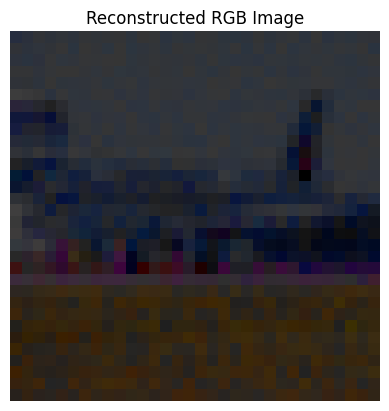

In [19]:
# recon_theta, recon_phi: shape = (1024,)
lut_df = load_lut_dataframe("LUT_theta_phi_bounds.csv")
matched_rgb = match_all_theta_phi(recon_theta, recon_phi, lut_df)
rgb_image = reshape_and_visualize(matched_rgb)

In [27]:
def block_quantize_rgb(image_255, block_size=4):
    """
    Quantize RGB values by block grouping. E.g., 0–3→0, 4–7→4, ..., 252–255→252
    """
    return (image_255 // block_size * block_size).astype(np.uint8)


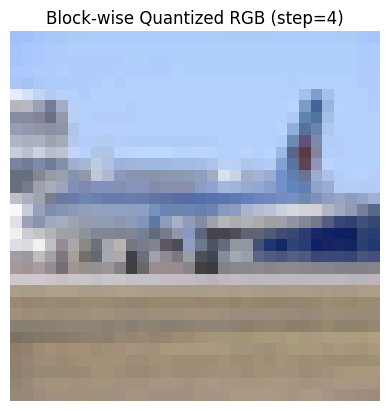

In [28]:
airplane = cv2.imread("airplane1.png")
airplane_rgb = cv2.cvtColor(airplane, cv2.COLOR_BGR2RGB)
quantized = block_quantize_rgb(airplane_rgb)

import matplotlib.pyplot as plt
plt.imshow(quantized)
plt.axis('off')
plt.title("Block-wise Quantized RGB (step=4)")
plt.show()


In [30]:
# (1) 이미지 불러오기 (BGR → RGB 변환)
airplane = cv2.imread("airplane1.png")
airplane_rgb = cv2.cvtColor(airplane, cv2.COLOR_BGR2RGB)
airplane_flat = airplane_rgb.flatten()
airplane_flat_norm = block_quantize_rgb(airplane_flat, block_size=4)
airplane_norm_reshape = airplane_flat_norm.reshape((-1,3))
airplane_norm_reshape_final = np.array(airplane_norm_reshape, dtype=np.uint8)

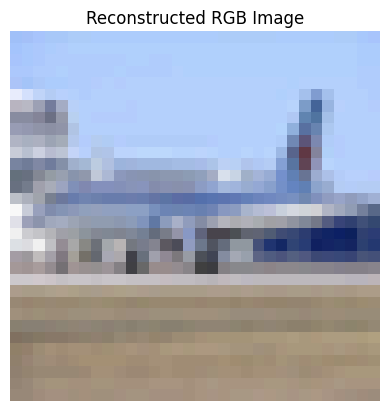

In [31]:
airplane_norm = reshape_and_visualize(airplane_norm_reshape_final)

In [289]:
import numpy as np

# (1) float32로 변환 (오차 정밀도 유지)
original = airplane_norm.astype(np.float32)
reconstructed = rgb_image.astype(np.float32)

# (2) 전체 RGB 차이의 MSE
mse = np.mean((original - reconstructed) ** 2)
print("전체 평균 RGB MSE:", mse)


전체 평균 RGB MSE: 74.91471


In [ ]:
# (3) 각 픽셀별 RGB MSE (3채널 평균)
pixelwise_mse = np.mean((original - reconstructed) ** 2, axis=2)  # shape: (32, 32)

In [292]:
import pandas as pd

records = []
for y in range(32):
    for x in range(32):
        err = pixelwise_mse[y, x]
        if err > 0:
            records.append({
                'x': x,
                'y': y,
                'mse': err,
                'original_rgb': original[y, x],
                'reconstructed_rgb': reconstructed[y, x]
            })

df_rgb_mse = pd.DataFrame(records)
df_rgb_mse_sorted = df_rgb_mse.sort_values(by='mse', ascending=False)

# 상위 5개 출력
print(df_rgb_mse_sorted.head(5))


      x   y         mse        original_rgb   reconstructed_rgb
662  22  20  693.666687  [35.0, 34.0, 35.0]   [61.0, 7.0, 61.0]
660  20  20  610.000000  [35.0, 34.0, 36.0]   [9.0, 11.0, 61.0]
658  18  20  546.000000  [33.0, 32.0, 33.0]   [55.0, 7.0, 56.0]
653  13  20  545.333313  [39.0, 36.0, 36.0]  [61.0, 12.0, 12.0]
622  14  19  526.666687  [31.0, 30.0, 32.0]   [29.0, 0.0, 58.0]


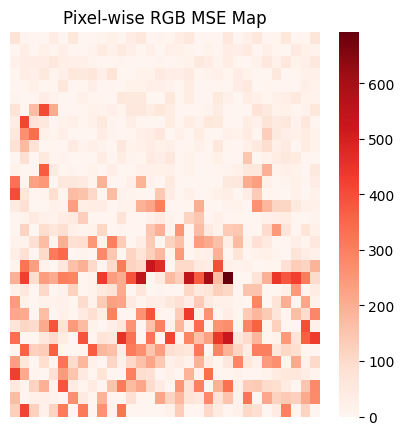

In [293]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 5))
sns.heatmap(pixelwise_mse, cmap='Reds', cbar=True)
plt.title("Pixel-wise RGB MSE Map")
plt.axis('off')
plt.show()
